In [2]:
""" ACTIVE JUPYTER NOTEBOOK TO BATCH RUN UNIT MATCHING ALGORITHM """

# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2


In [3]:
# Outside imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt

# Set necessary paths / make project path = ...../neuroscikit/
analysis_path = os.getcwd()
prototype_path = os.path.abspath(os.path.join(analysis_path, os.pardir))
project_path = os.path.abspath(os.path.join(prototype_path, os.pardir))
lab_path = os.path.abspath(os.path.join(project_path, os.pardir))
out_path = os.path.abspath(os.path.join(lab_path, os.pardir))
sys.path.append(project_path)
os.chdir(project_path)
print(project_path)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit


In [4]:
# Internal imports

# Read write modules
from x_io.rw.axona.batch_read import make_study
from _prototypes.unit_matcher.read_axona import read_sequential_sessions, temp_read_cut
from _prototypes.unit_matcher.write_axona import format_new_cut_file_name

# Unit matching modules
from _prototypes.unit_matcher.main import format_cut, run_unit_matcher, map_unit_matches_first_session, map_unit_matches_sequential_session
from _prototypes.unit_matcher.session import compare_sessions
from _prototypes.unit_matcher.waveform import time_index, derivative, derivative2, morphological_points

# External imports

# import math
# from sklearn import linear_model
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.genmod.families import Poisson, Gaussian
# from sklearn.metrics import r2_score
# from statsmodels.genmod.families.links import identity, log


In [5]:
""" If a setting is not used for your analysis (e.g. smoothing_factor), just pass in an arbitrary value or pass in 'None' """
STUDY_SETTINGS = {

    'ppm': 511,  # EDIT HERE

    'smoothing_factor': None, # EDIT HERE

    'useMatchedCut': False,  # EDIT HERE, set to False if you want to use runUnitMatcher, set to True after to load in matched.cut file
}


# Switch devices to True/False based on what is used in the acquisition (to be extended for more devices in future)
device_settings = {'axona_led_tracker': True, 'implant': True} 

# Make sure implant metadata is correct, change if not, AT THE MINIMUM leave implant_type: tetrode
implant_settings = {'implant_type': 'tetrode', 'implant_geometry': 'square', 'wire_length': 25, 'wire_length_units': 'um', 'implant_units': 'uV'}

# WE ASSUME DEVICE AND IMPLANT SETTINGS ARE CONSISTENCE ACROSS SESSIONS

# Set channel count + add device/implant settings
SESSION_SETTINGS = {
    'channel_count': 4, # EDIT HERE, default is 4, you can change to other number but code will check how many tetrode files are present and set that to channel copunt regardless
    'devices': device_settings, # EDIT HERE
    'implant': implant_settings, # EDIT HERE
}

STUDY_SETTINGS['session'] = SESSION_SETTINGS

settings_dict = STUDY_SETTINGS

In [6]:
# data_dir = lab_path + r'\neuroscikit_test_data\20180530-ROUND-3300-1X2B3A' 
data_dir = lab_path + r'\neuroscikit_test_data\LEC_odor\AD\Odor_119a-6'

# To use in unit matching
settings_dict_unmatched = settings_dict
settings_dict_unmatched['useMatchedCut'] = True

study = make_study([data_dir], settings_dict_unmatched)
study.make_animals()

Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal

In [7]:
""" FUNCTIONS """

def event_times_to_count(spike_object):
    dt = 0.5
    new_time_index = np.arange(0,spike_object.time_index[-1],dt)
    ct, bins = np.histogram(spike_object.event_times, bins=new_time_index)
    # print(ct.shape, bins[:-1].shape)
    return ct, bins[:-1]


def aggregate_event_times(study):
    agg_events = []
    agg_event_objects = []
    agg_events_binary = []
    prev_time_index = None
    for animal in study.animals:
        for ses in animal.ensembles:
            for cell in animal.ensembles[ses].cells:
                agg_events.append(cell.event_times)
                agg_event_objects.append(cell)
                ct, time_index = event_times_to_count(cell.cluster)
                if prev_time_index is not None:
                    assert time_index.all() == prev_time_index.all()
                agg_events_binary.append(ct)
                # agg_time_index.append(time_index)
                prev_time_index = time_index
                
    return agg_events, np.array(agg_event_objects), np.array(agg_events_binary), np.array(time_index)


In [8]:
from x_io.rw.axona.read_eeg_or_egf import load_eeg_or_egf_from_path

In [9]:
# eeg = load_eeg_or_egf_from_path(r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\20180530-ROUND-3300-1X2B3A\tint_files\20180530-ROUND-3300-1X2B3A.eeg")
eeg = load_eeg_or_egf_from_path(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_odor\AD\Odor_119a-6\ANT-119a-6_20170606-3100-odorxba.eeg') # periodic???
# eeg = load_eeg_or_egf_from_path(r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_odor\AD\Odor_119a-6\ANT-119a-6_20170608-3350-odorxba.eeg")
# eeg = load_eeg_or_egf_from_path(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_odor\AD\Odor_119a-6\ANT-119a-6_20170713-2150-odorxba.eeg')


# eeg = eeg/10

In [41]:
animal.sessions['session_1']

In [10]:
animal = study.get_animal_by_id('Odor_119a-6_tet1')
eeg_fs = 250 # Hz
eeg_dt = 1/eeg_fs # s
trialT = 50 # seconds
sessionT = animal.sessions['session_1'].get_spike_data()['spike_cluster'].time_index[-1]
time = animal.sessions['session_1'].get_spike_data()['spike_cluster'].time_index

eegT = np.arange(0,sessionT,eeg_dt)

In [11]:
animal.sessions['session_23'].session_metadata.file_paths

{'cut': 'c:\\Users\\aaoun\\OneDrive - cumc.columbia.edu\\Desktop\\HussainiLab\\neuroscikit_test_data\\LEC_odor\\AD\\Odor_119a-6/ANT-119a-6_20170713-2150-odorxba_1_matched.cut',
 'tet': 'c:\\Users\\aaoun\\OneDrive - cumc.columbia.edu\\Desktop\\HussainiLab\\neuroscikit_test_data\\LEC_odor\\AD\\Odor_119a-6/ANT-119a-6_20170713-2150-odorxba.1',
 'pos': 'c:\\Users\\aaoun\\OneDrive - cumc.columbia.edu\\Desktop\\HussainiLab\\neuroscikit_test_data\\LEC_odor\\AD\\Odor_119a-6/ANT-119a-6_20170713-2150-odorxba.pos',
 'ppm': 300.0}

In [12]:
def convert_egg_to_trials(eeg, time, trial_start_times, trial_length):
    dt = time[1] - time[0]
    trials = []
    trial_times = []

    for i in range(len(trial_start_times)):
        start = trial_start_times[i]

        idx = np.where(start >= time)[0][-1]

        window = int(trial_length/dt)
        
        trial = eeg[idx : idx + window]
        trial_time = time[idx : idx + window]

        trials.append(trial)
        trial_times.append(trial_time)

    return np.asarray(trials), np.asarray(trial_times)

In [13]:
trial_count = 4
trial_start_times = np.arange(0,trial_count * trialT, trialT)

eeg_trials, eeg_trial_times = convert_egg_to_trials(eeg, eegT, [0,50,110,70], trialT)

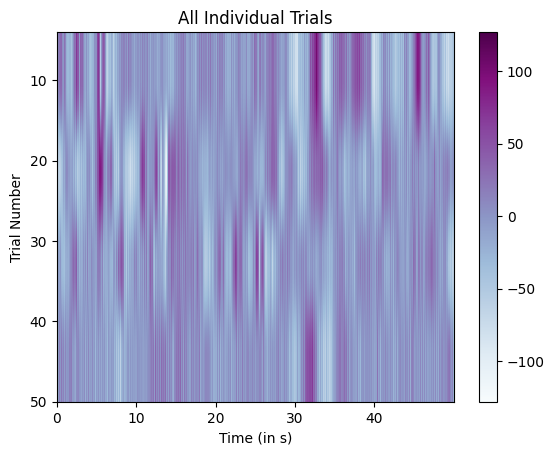

In [14]:
plt.imshow(eeg_trials, cmap='BuPu', aspect='auto', origin='lower', extent=[eeg_trial_times[0][0], eeg_trial_times[0][-1], trialT, trial_count])                        
plt.xlabel('Time (in s)')                           
plt.ylabel('Trial Number')
plt.colorbar()                                     
plt.title("All Individual Trials")              
plt.show()

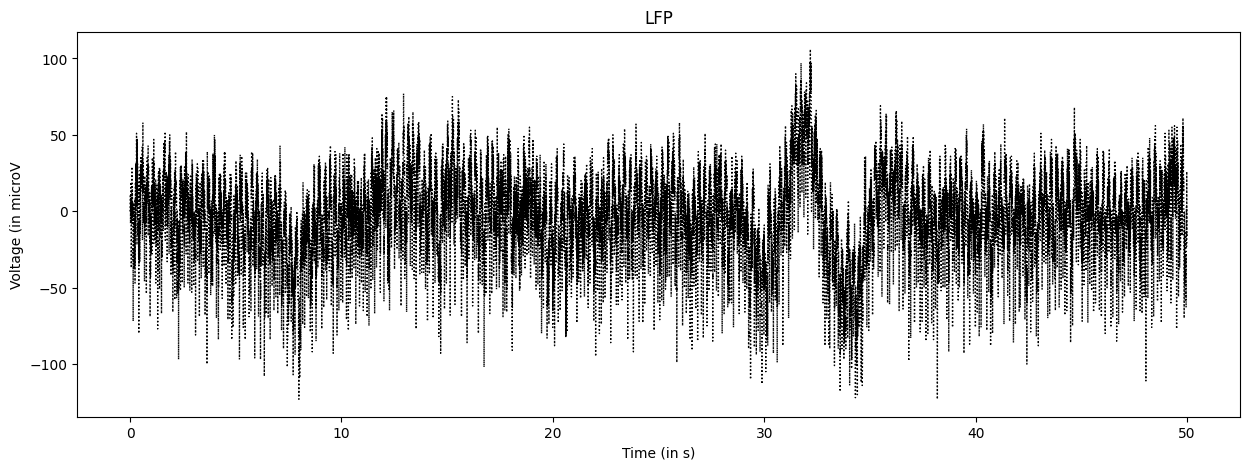

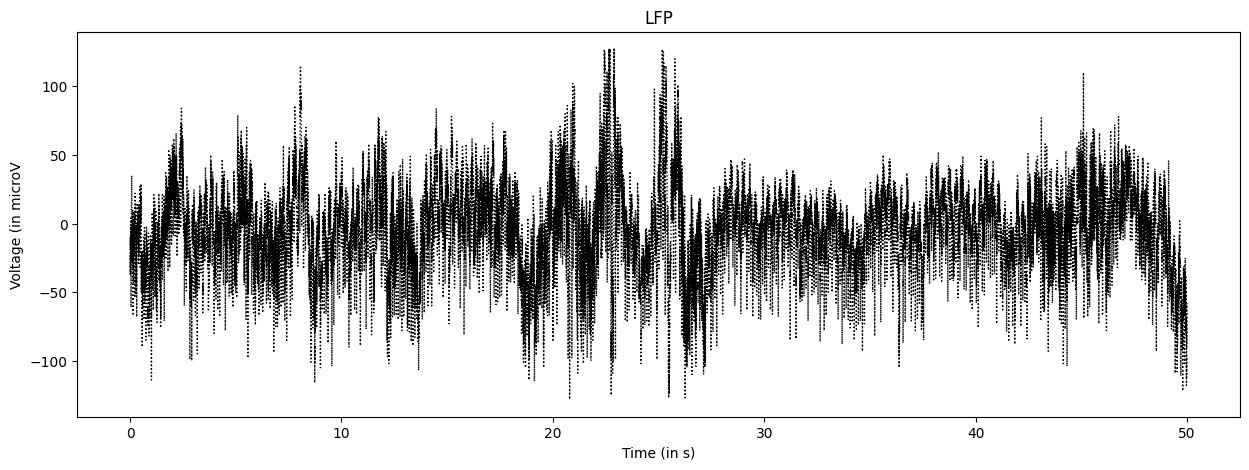

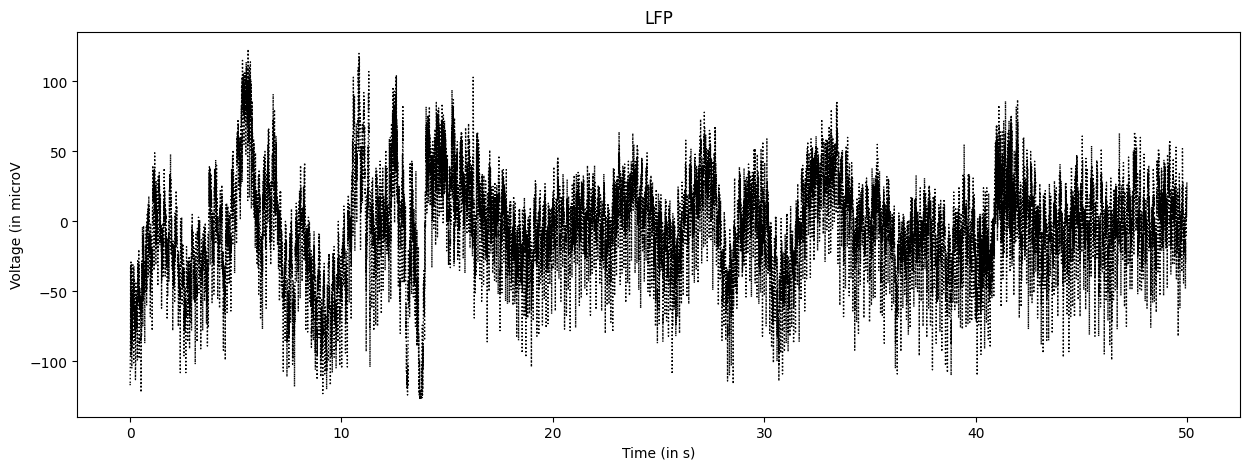

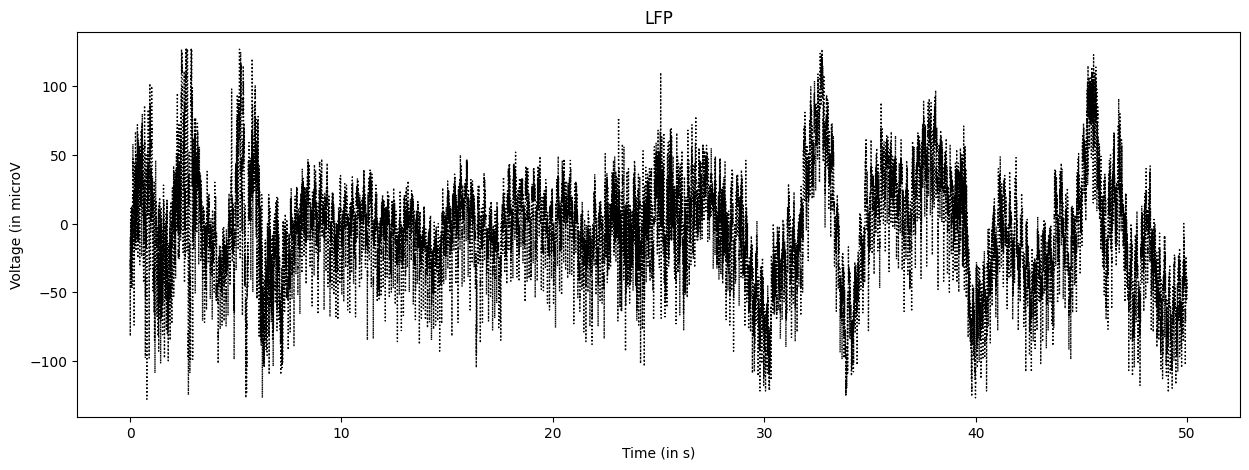

In [15]:
for i in range(4):
    plt.subplots(figsize=(15, 5))
    plt.plot(eeg_trial_times[0], eeg_trials[i], 'k:', lw=1)
    plt.xlabel('Time (in s)')                           
    plt.ylabel('Voltage (in microV')
    plt.title('LFP')
    # plt.vlines(0, np.min( eeg_trials[0]), np.max( eeg_trials[0]), 'b')
    # plt.vlines(30, np.min( eeg_trials[0]), np.max( eeg_trials[0]), 'b')
    plt.show()

In [16]:

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from scipy.stats.distributions import chi2
from spectrum import dpss, nextpow2
from matplotlib import colors

from multitaper_spectrum import mtSpec

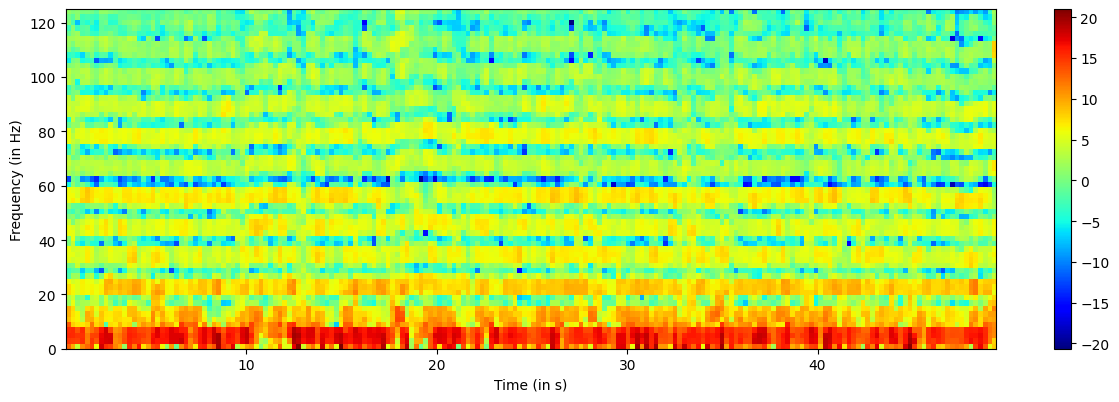

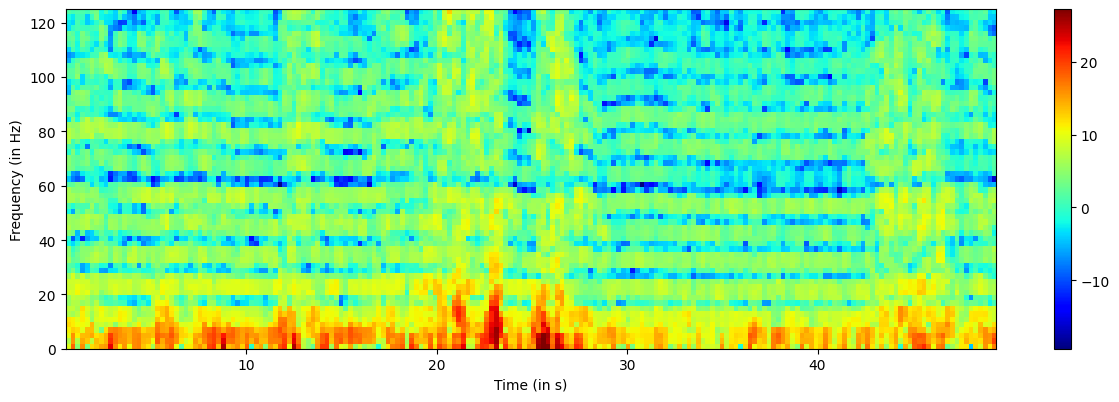

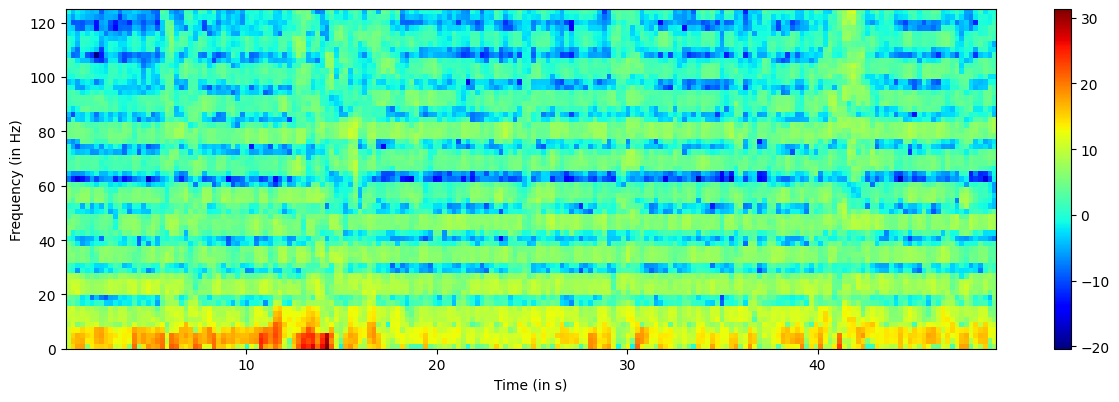

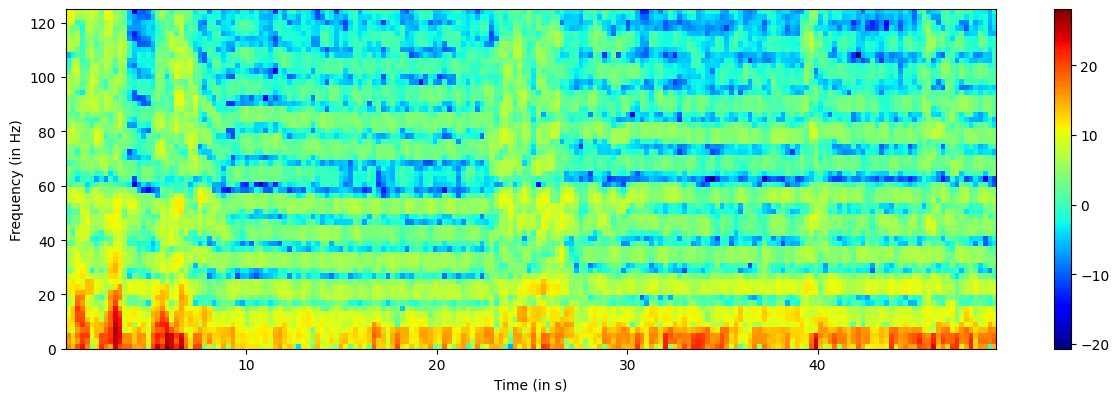

In [17]:

for i in range(len(eeg_trials)):
    LFP = eeg_trials[i]
    N = len(eeg_trial_times[i]) # 110000
    T = eeg_trial_times[0][-1] # 110 seconds
    sfreq = N/T # 
    t = eegT
    assert int(sfreq) == 250
    dt = 1/sfreq # 1/1000
    W = 0.5 # 0.5 seconds
    df = 1/W # 2
    n = int(sfreq*0.5) # size of time window in sampling points
    R = 8
    step = int(n/2)  

    # NUMBER OF TIMES FOR LOOP RUNS
    J = 0
    for k in range(n, N-n, step): # = 436 by the end
        J += 1 

    Sp = np.zeros((step+1, J))
    Sh = np.zeros((step+1, J))
    Smt = np.zeros((step+1, J))

    tt = np.zeros(J)
    X = LFP - np.mean(LFP) 

    j = 0 # keep track of the number of steps we are at (so we will have 110 000/(n/2) = 440 steps of size W/2)
    for k in range(n, N-n, step):
        tt[j]=t[k]
        x = X[k-n:k] 

        # # Rectangular taper
        # xp = np.fft.fft(x) 
        # pp = dt * dt * df * np.square(np.absolute(xp))
        # i = int(len(xp)/2+1)
        # pp = 2 * pp[0:i] 
        # Sp[:,j] = pp          
        
        # # Hann taper
        # hanning = np.hanning(n)
        # xh = np.fft.fft((x*hanning)) 
        # i = int(len(xh)/2+1)
        # ph = dt * dt * df * np.square(np.absolute(xh))
        # ph = 2 * pp[0:i] 
        # Sh[:,j] = ph

        # Multitaper   
        pm, _, _, _, _, Fm, nTapers = mtSpec(x, x, sfreq, R, n, True, True, [])
        Smt[:,j] = pm
        j += 1

    # S = [Sp, Sh, Smt]
    S = [Smt]

    extent=[np.min(tt), np.max(tt), np.min(Fm), np.max(Fm)]
    c = 1
    fig = plt.figure(figsize=(15,15))
    for s in S:
        ax = fig.add_subplot(3, 1, c)
        ax.set_xlabel("Time (in s)")
        ax.set_ylabel("Frequency (in Hz)")
        # ax.set_ylim(0,100)
        # ax.set_ylim(3.5,7)
        im = ax.imshow(10*np.log10(s), aspect='auto', cmap='jet', interpolation='none', origin='lower', extent=extent) 
        fig.colorbar(im, ax=ax)
        c += 1




49


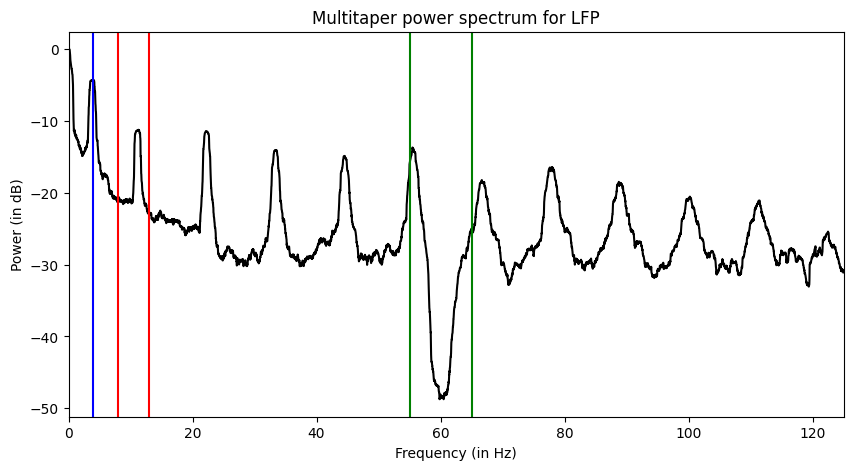

49


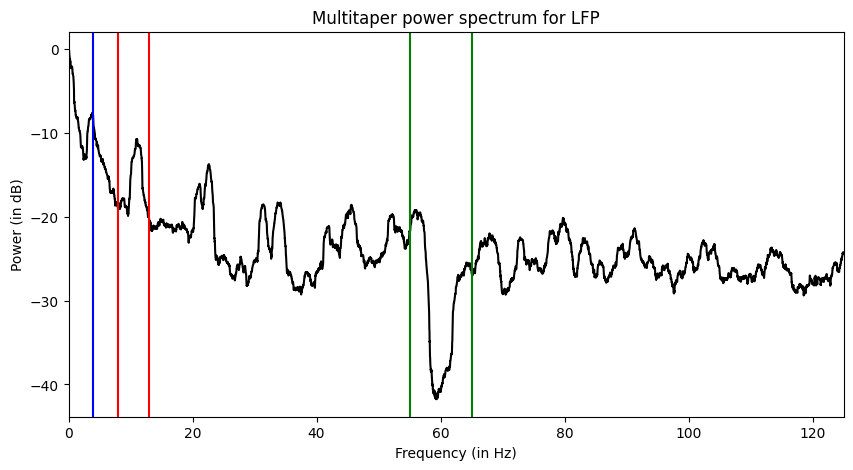

49


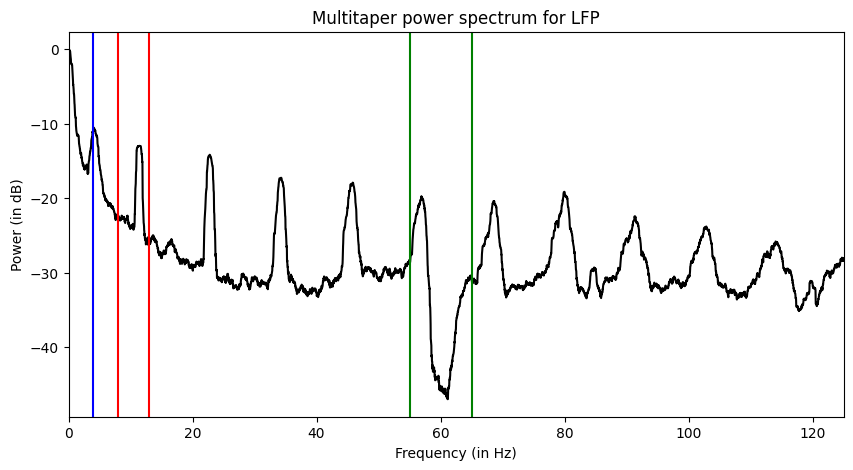

49


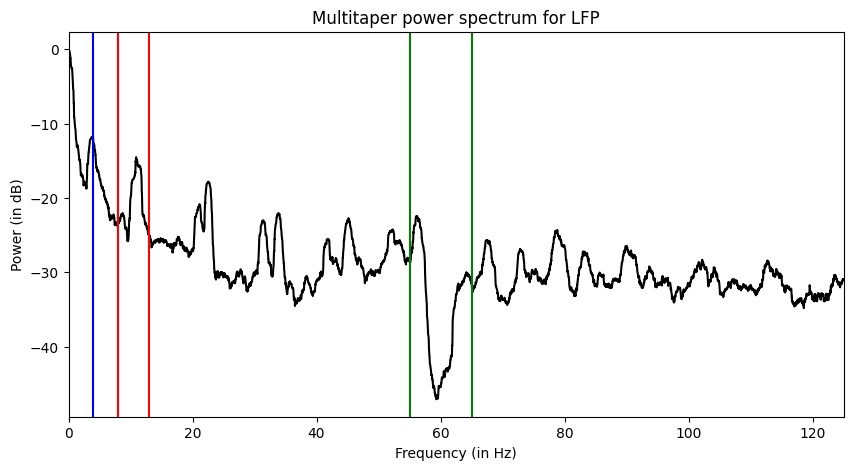

In [18]:

for i in range(len(eeg_trial_times)):
    t = eeg_trial_times[0]
    X = eeg_trials[i]
    N = len(X) 
    Fs = 250
    fNQ = float(Fs/2)
    ntapers = []

    NFFT = N
    R = 1

    mps, _, _, _, _, F, ntapers = mtSpec(X, X, Fs, R, N, False, True, ntapers)
    print(ntapers)
    fig = plt.figure(figsize=(10,5))
    plt.plot(F, 10*np.log10(mps/np.max(mps)), 'k')
    plt.xlabel('Frequency (in Hz)')
    plt.ylabel('Power (in dB)')
    plt.title('Multitaper power spectrum for LFP')
    plt.xlim(0,125)
    plt.axvline(4,color='b')
    # plt.axvline(4)
    plt.axvline(55,color='g')
    plt.axvline(65,color='g')
    plt.axvline(13, color='r')
    plt.axvline(8,color='r')
    plt.show()

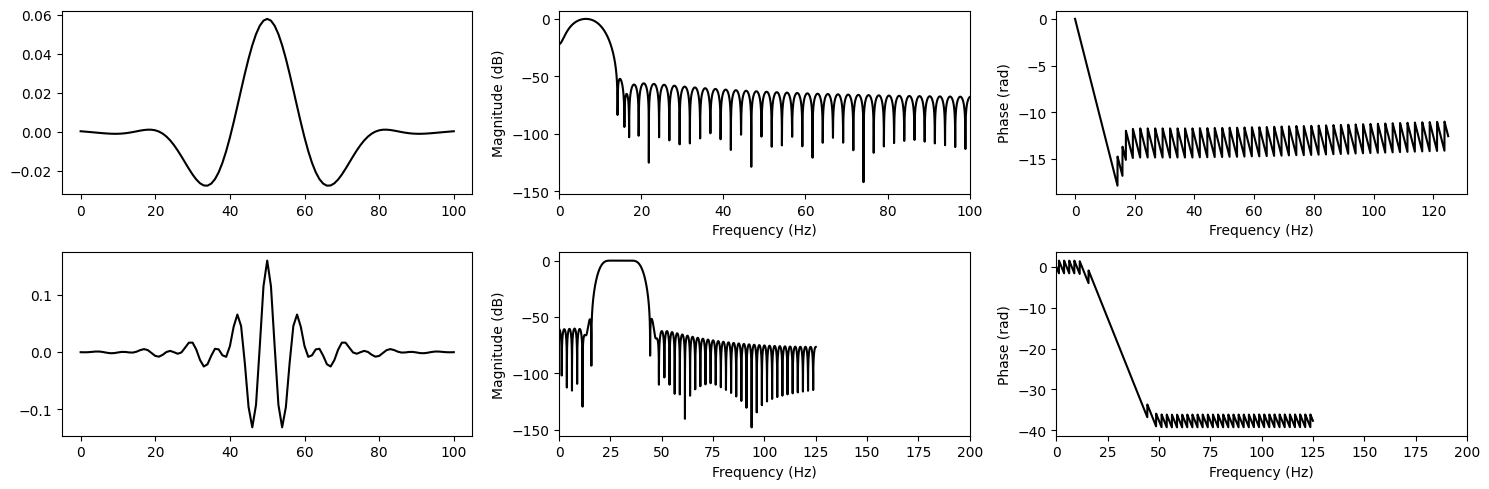

In [20]:
dt = eegT[1]-eegT[0]
Fs = 1/dt
# Fs = 250
fNQ = Fs/2
a = 1

Wn = [3, 10] 
n = 101
b1 = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming')

Wn = [20, 40] 
n = 101 
b2 = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming')

b = [b1,b2]
w1 , h1 = signal.freqz(b1, a, F, fs=Fs)
w2 , h2 = signal.freqz(b2, a, F, fs=Fs)
h = [h1,h2]
fig = plt.figure(figsize=(15,5))
for c in range(2):
    for i in range(3):
        if i == 0:
            ax = fig.add_subplot(2, 3, 3*c + i + 1)
            ax.plot(b[c],'k')
        if i == 1:
            ax = fig.add_subplot(2, 3, 3*c + i + 1)
            ax.plot(F, 20 * np.log10(np.abs(h[c])), 'k')
            if c==0:
                ax.set_xlim(0, 100)
            else:
                ax.set_xlim(0, 200)
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Magnitude (dB)')
        if i == 2:
            ax = fig.add_subplot(2, 3, 3*c + i + 1)
            ax.plot(F, np.unwrap(np.angle(h[c])),'k') 
            if c ==1:
                ax.set_xlim(0,200)
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Phase (rad)')
fig.tight_layout()

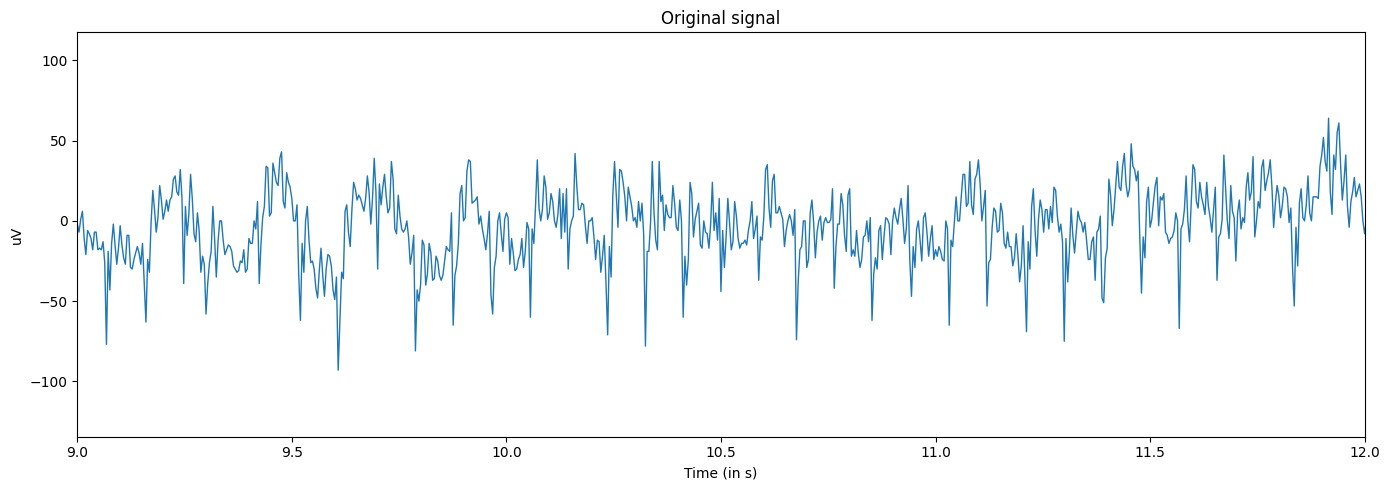

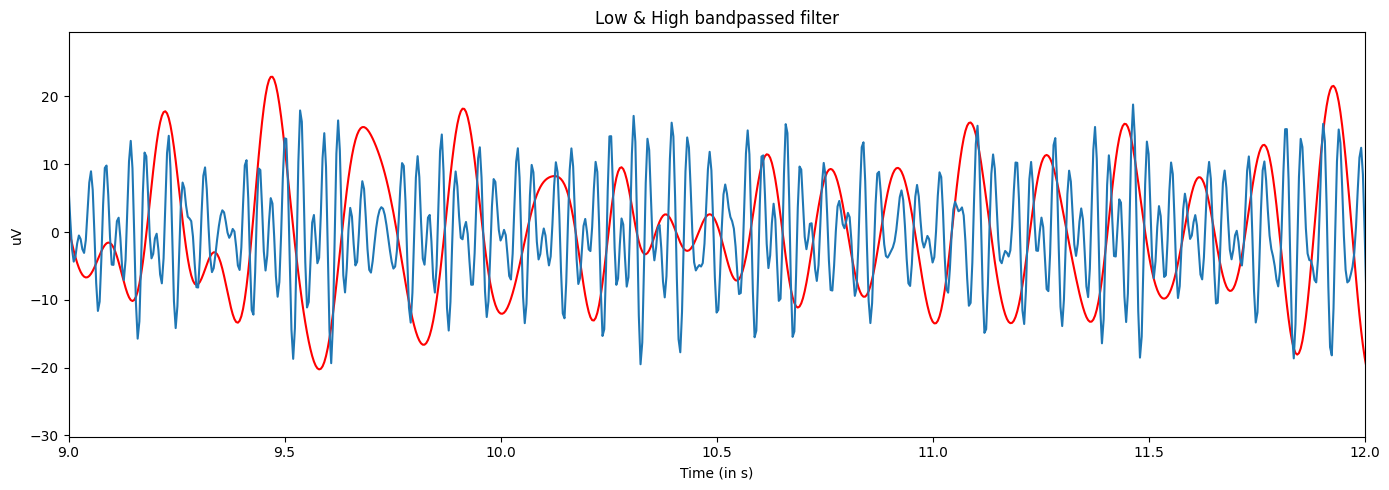

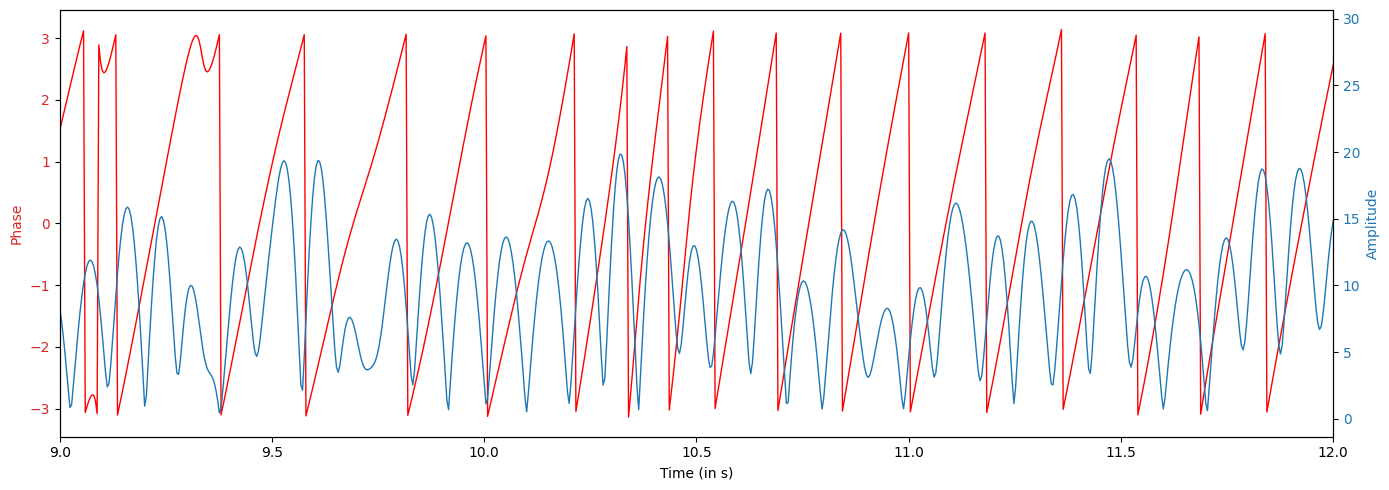

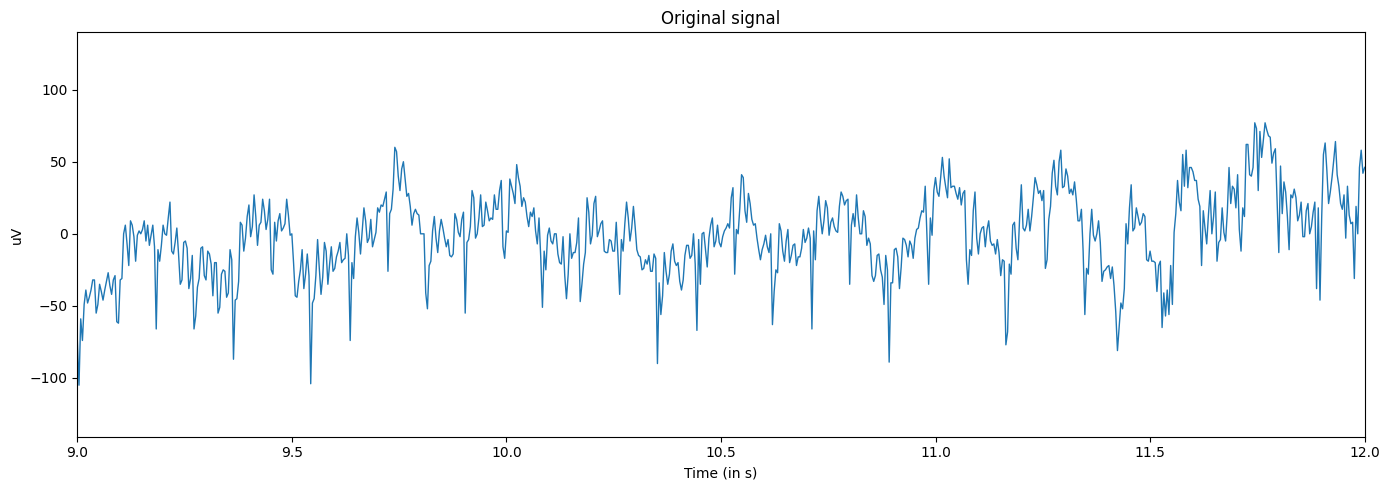

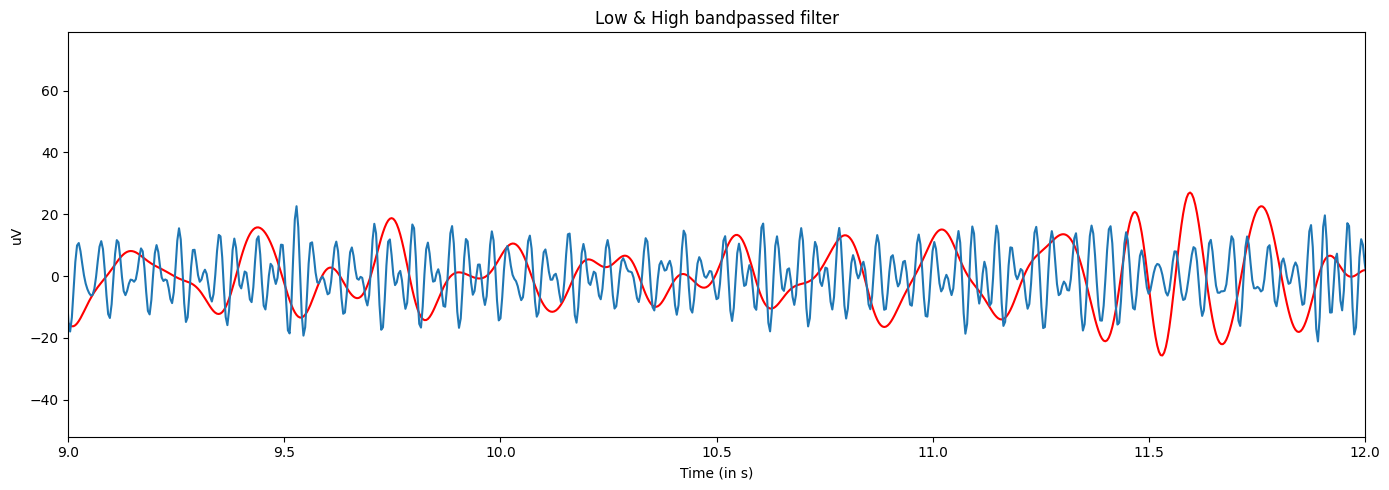

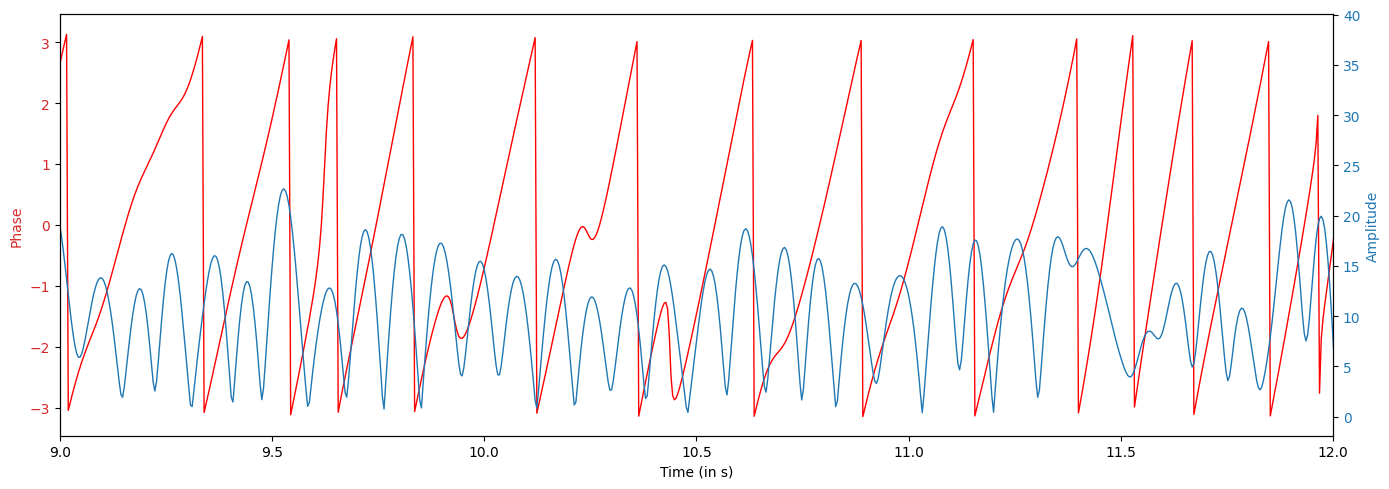

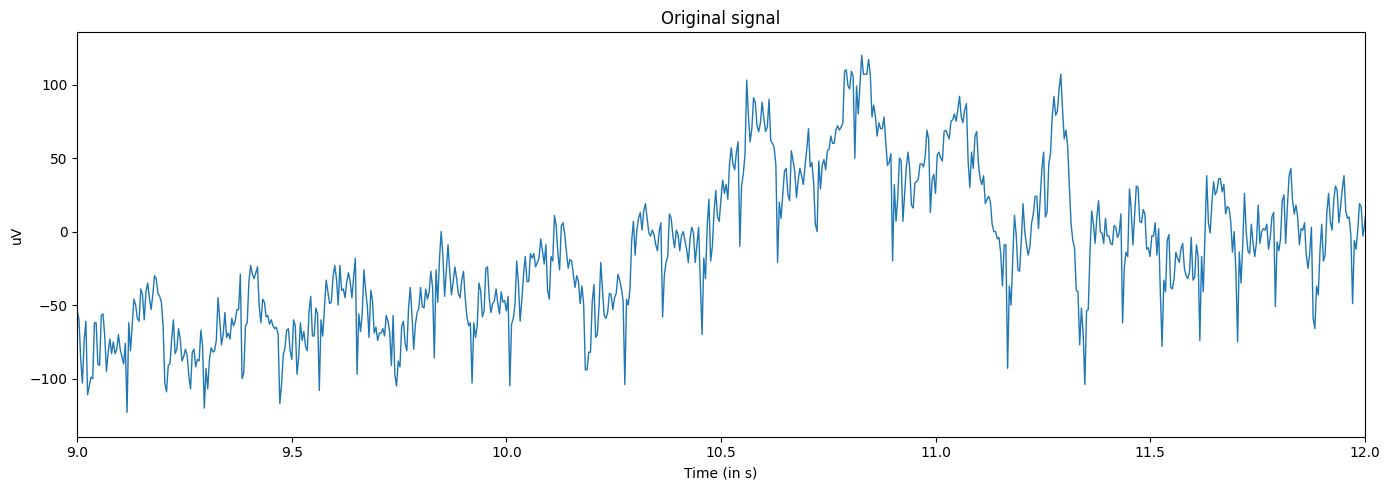

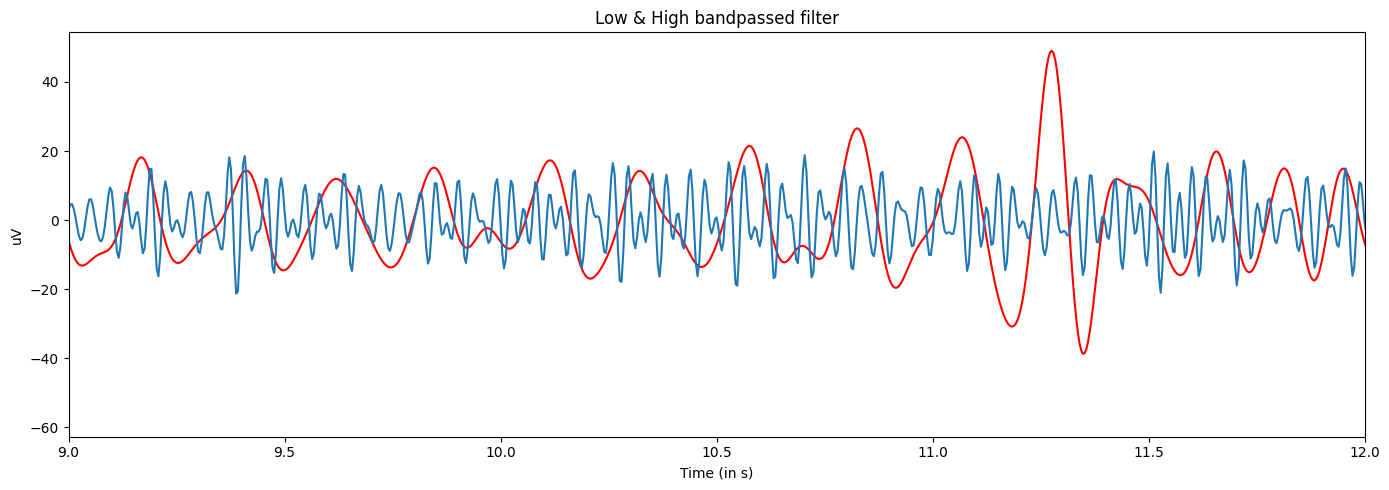

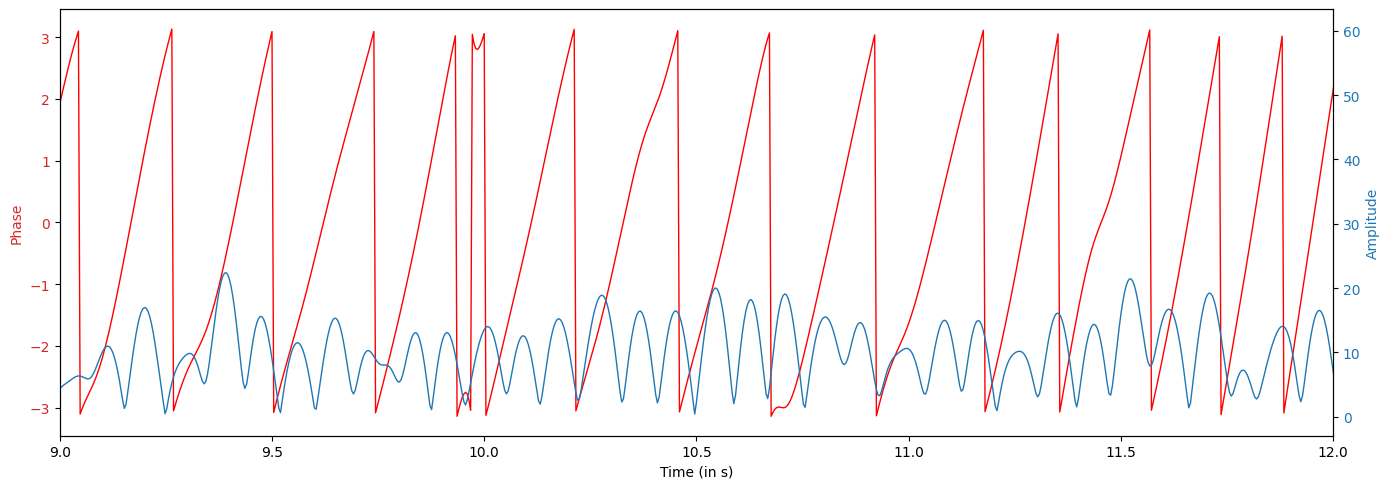

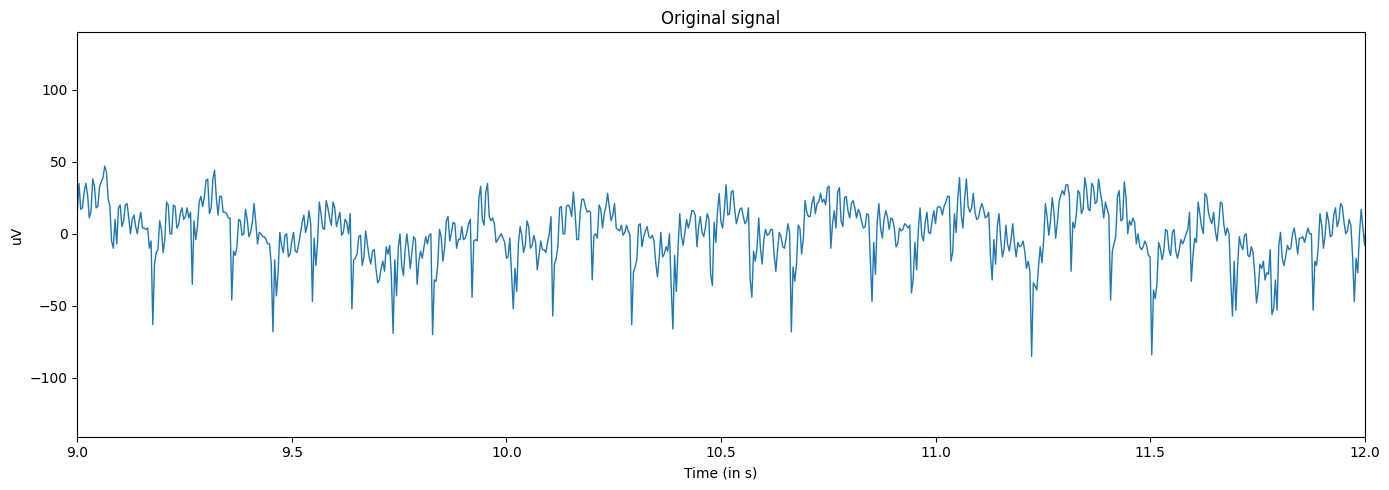

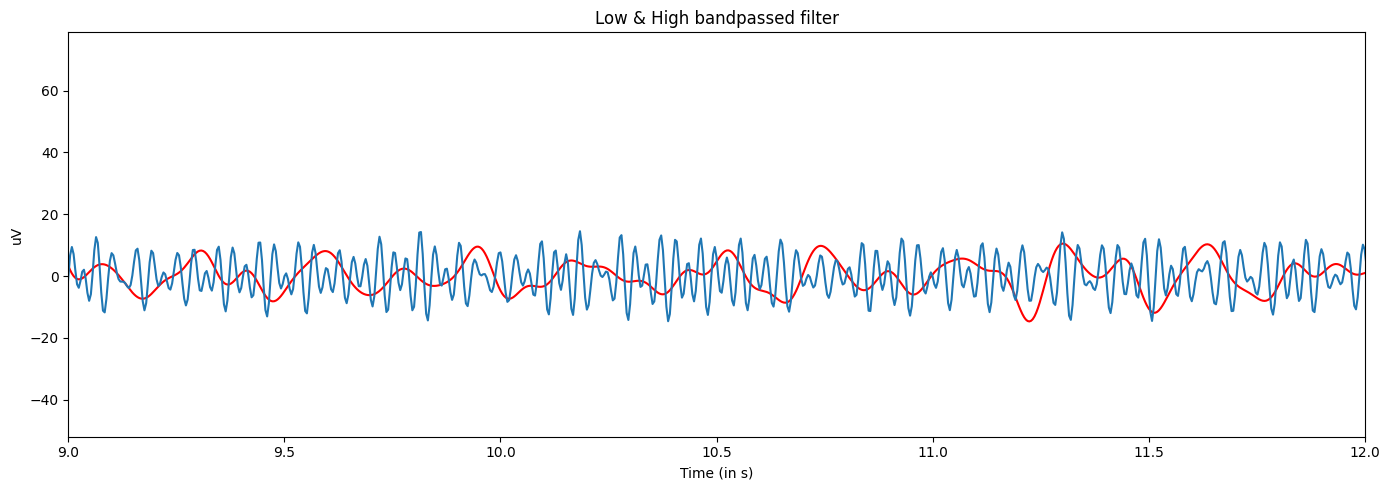

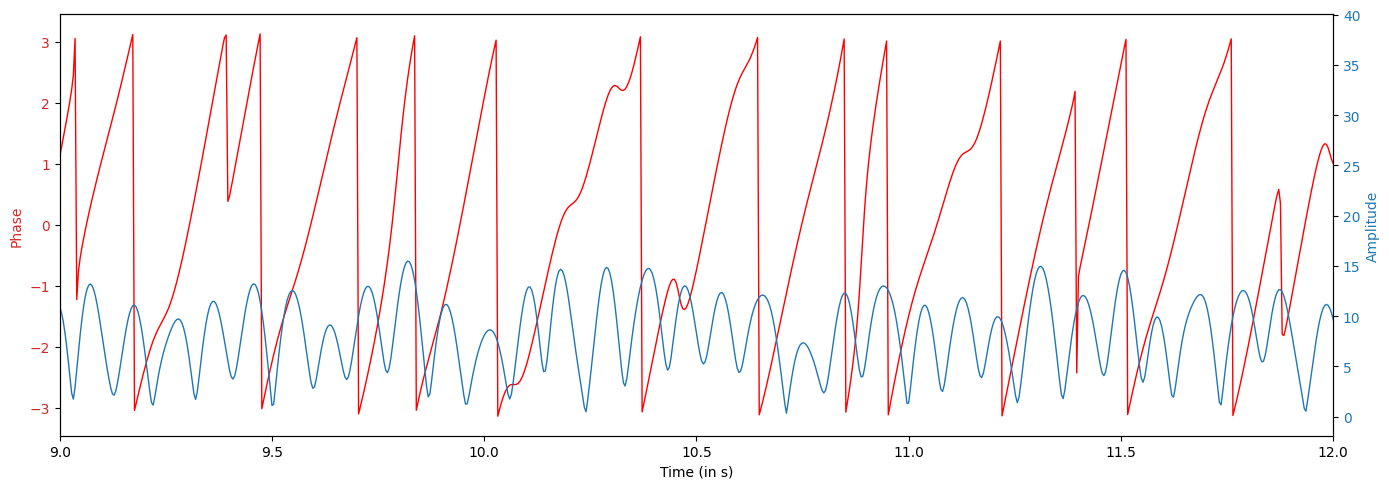

In [24]:
from scipy import signal

for i in range(len(eeg_trial_times)):

    Wn = [3, 10] 
    n = 101  
    b1 = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming')

    Wn = [20, 40] 
    n = 101
    b2 = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming')

    t = eeg_trial_times[0]
    X = eeg_trials[i]

    Vlo = signal.filtfilt(b1, 1, X)
    Vhi = signal.filtfilt(b2, 1, X)

    phi = np.angle(signal.hilbert(Vlo))   
    amp = np.abs(signal.hilbert(Vhi))

    start = 9
    end = 12

    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(1,1, 1)
    ax.plot(t, X, lw=1)
    ax.set_title('Original signal')
    ax.set_xlabel('Time (in s)')
    ax.set_ylabel('uV')
    ax.set_xlim(start,end)
    fig.tight_layout()


    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(1,1, 1)
    ax.plot(t, Vlo, 'r')
    ax.plot(t, Vhi)
    ax.set_title('Low & High bandpassed filter')
    ax.set_xlabel('Time (in s)')
    ax.set_ylabel('uV')
    ax.set_xlim(start,end)
    fig.tight_layout()


    fig, ax1 = plt.subplots(figsize=(14,5))

    color = 'tab:red'
    ax1.set_xlabel('Time (in s)')
    ax1.set_ylabel('Phase', color=color)
    ax1.plot(t, phi,'r', lw=1)
    ax1.set_xlim(start,end)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel('Amplitude', color=color)
    ax2.plot(t, amp, lw=1)
    # ax2.set_ylim(0,0.9)
    ax2.set_xlim(start,end)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()



In [55]:
b, a = signal.butter(8,0.125)
print(b, a)

[8.88199322e-07 7.10559458e-06 2.48695810e-05 4.97391620e-05
 6.21739525e-05 4.97391620e-05 2.48695810e-05 7.10559458e-06
 8.88199322e-07] [  1.          -5.98842478  15.88837987 -24.35723742  23.57037937
 -14.72938334   5.80019014  -1.31502712   0.13135067]


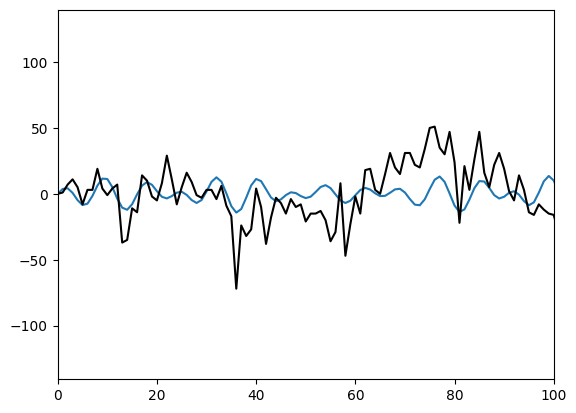

In [25]:
b1 = signal.firwin(101, Wn, nyq=fNQ, pass_zero=False, window='hamming')

sig = signal.filtfilt(b1, 1, eeg[:])

plt.plot(sig)
plt.plot(eeg[:],'k')
plt.xlim(0,100)

plt.show()

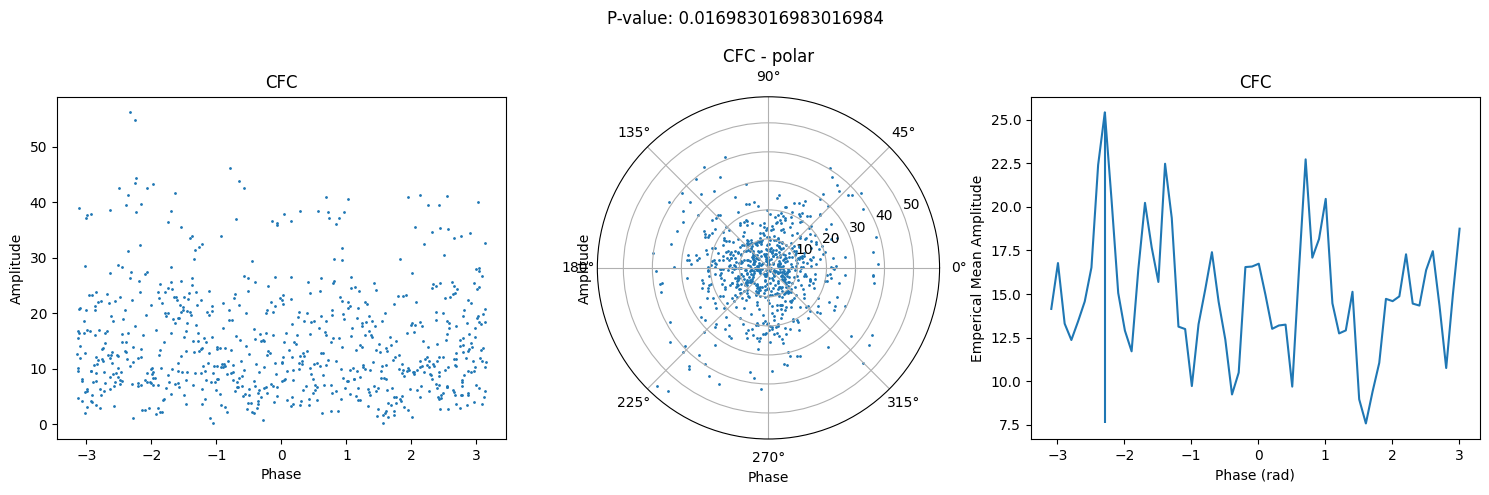

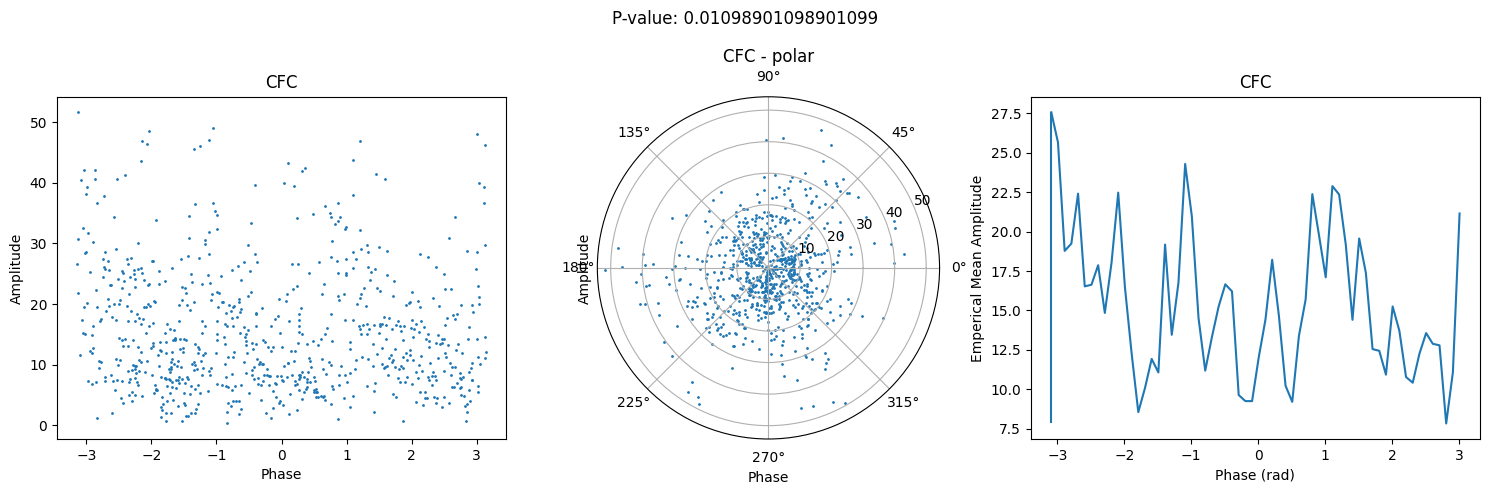

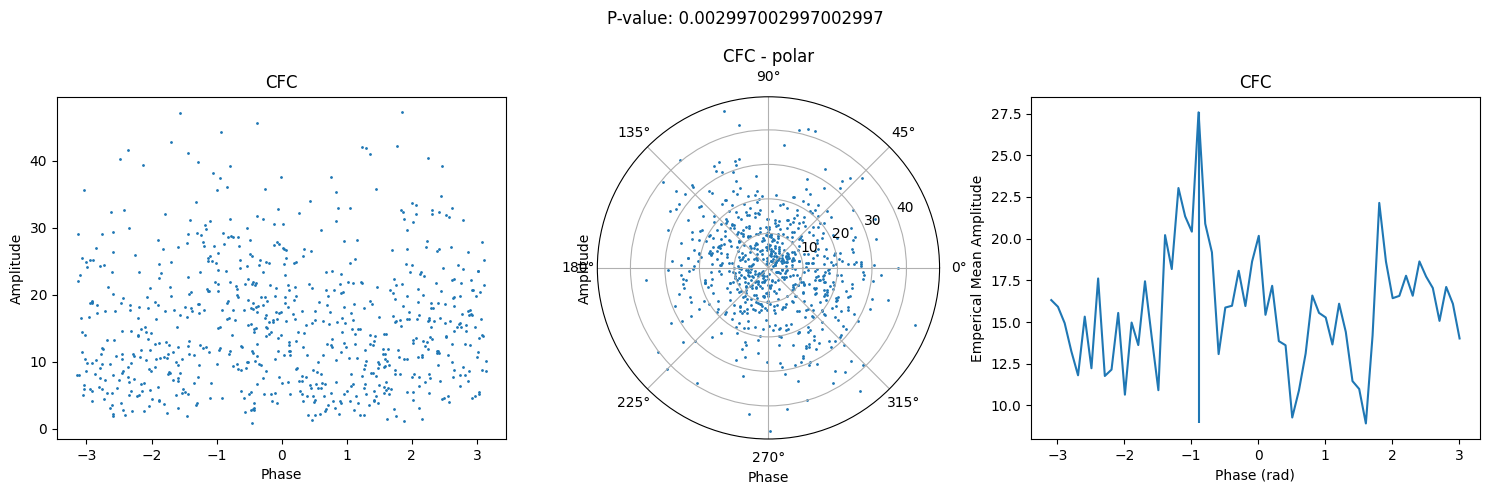

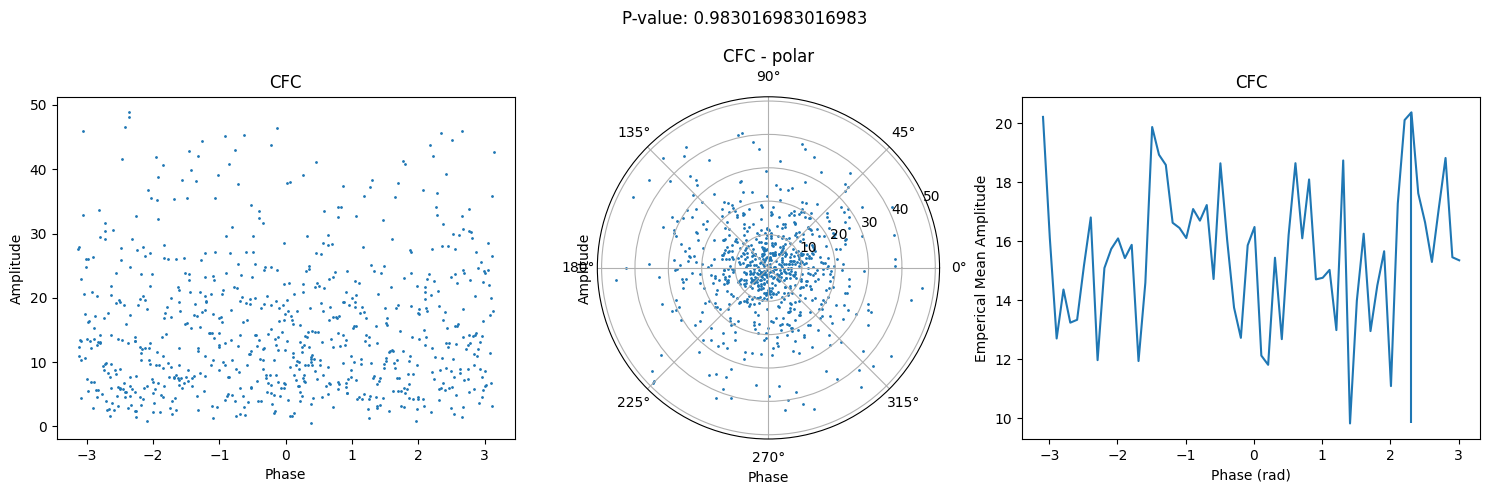

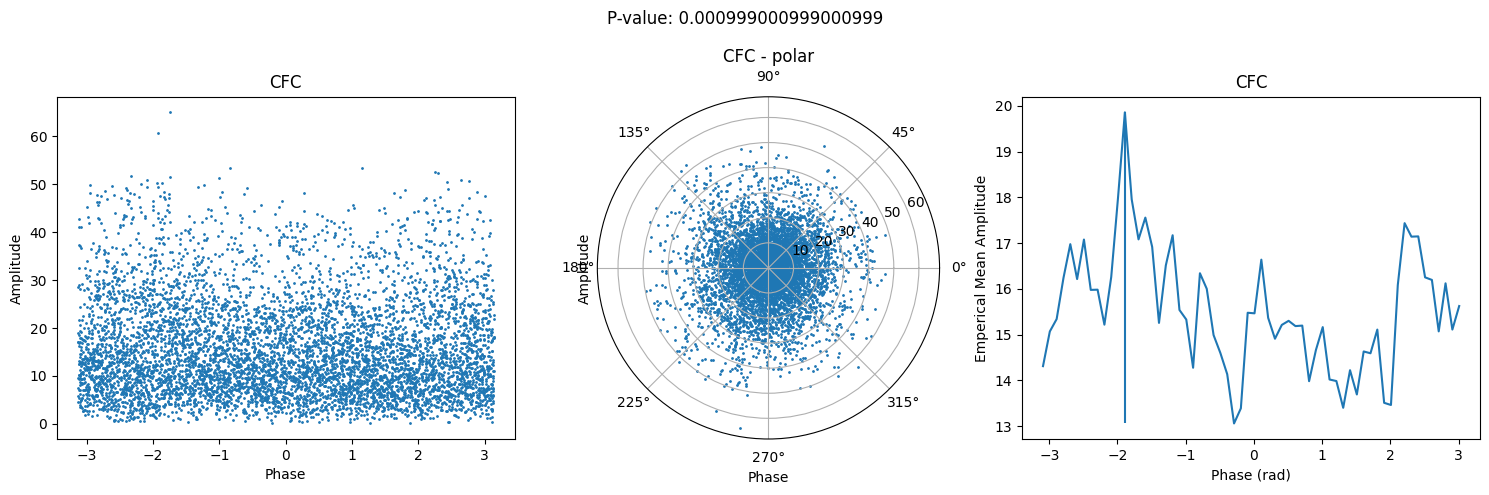

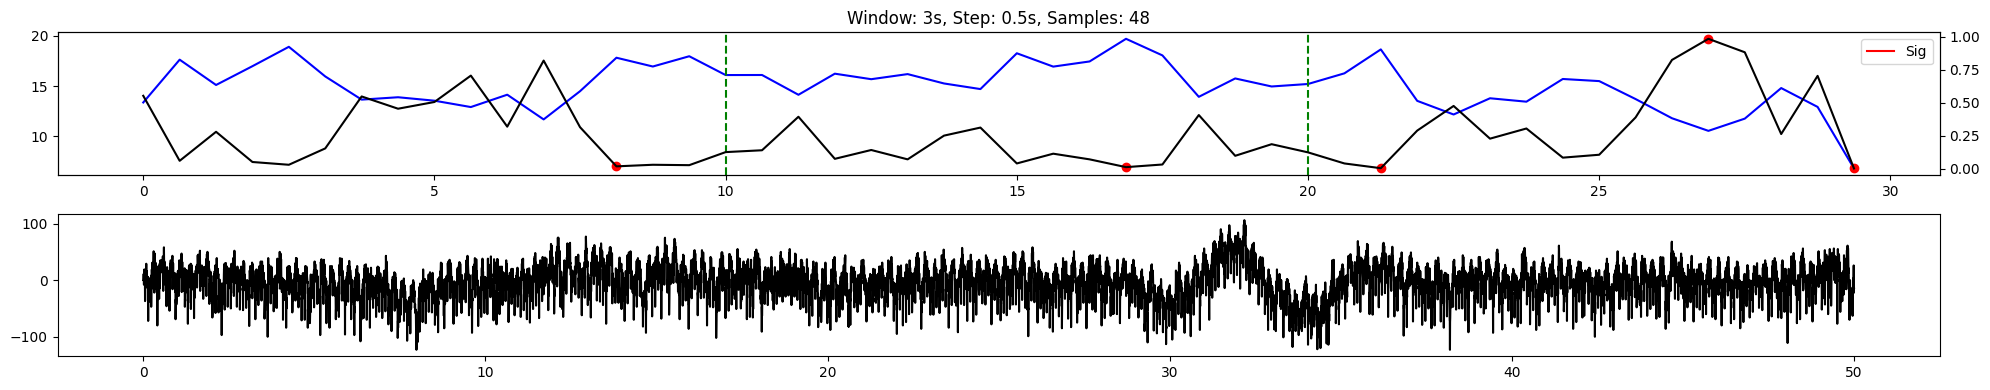

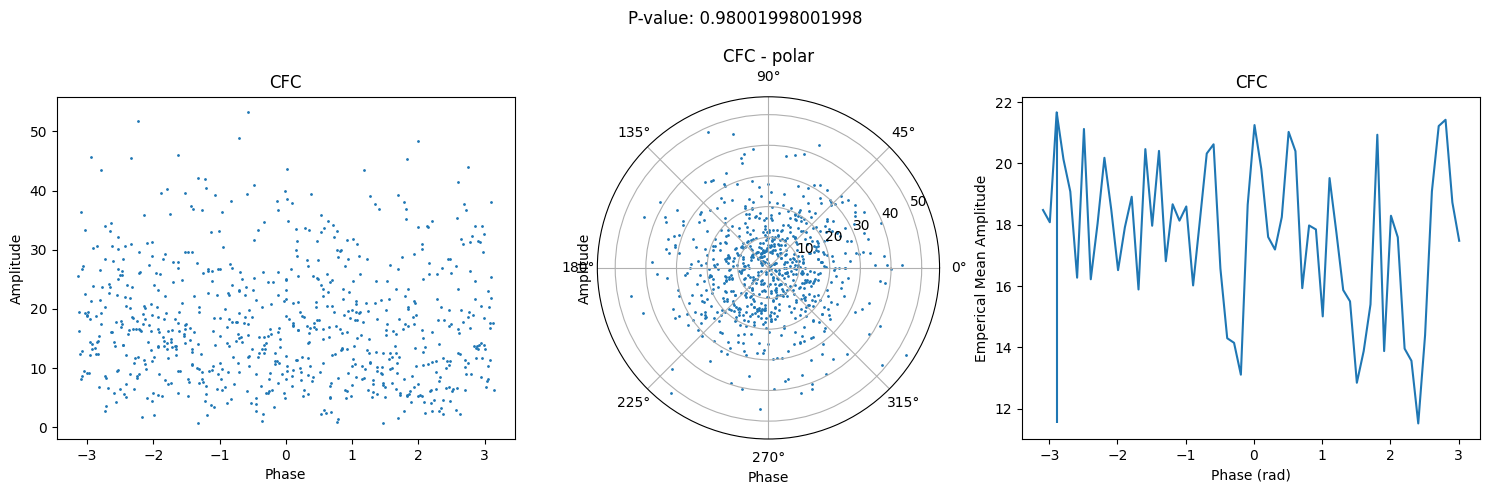

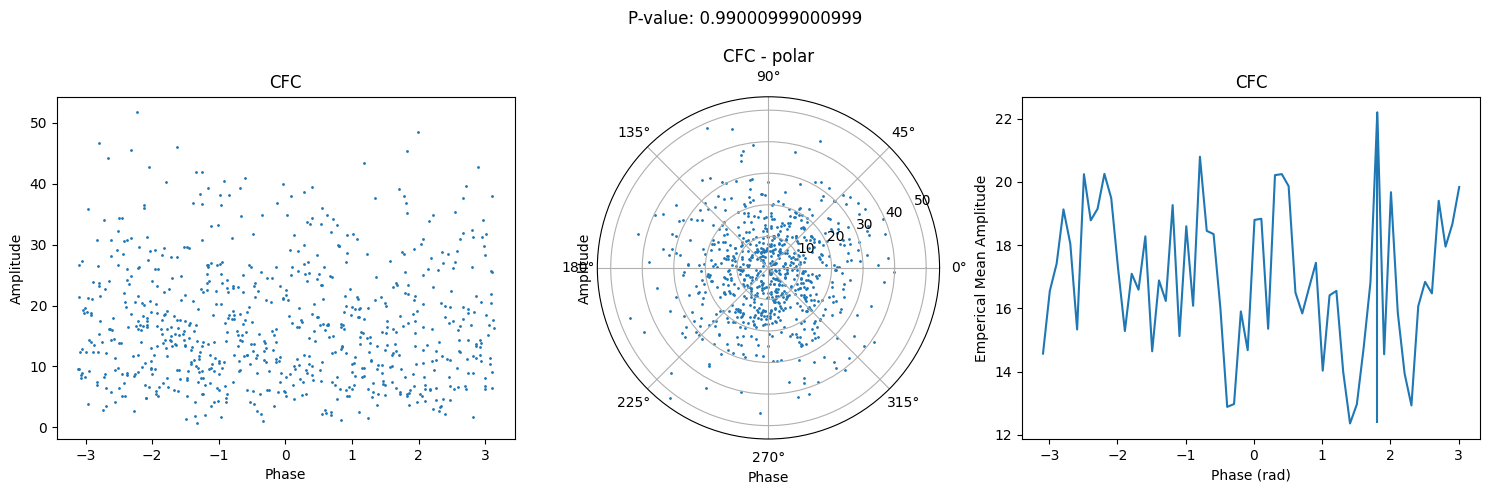

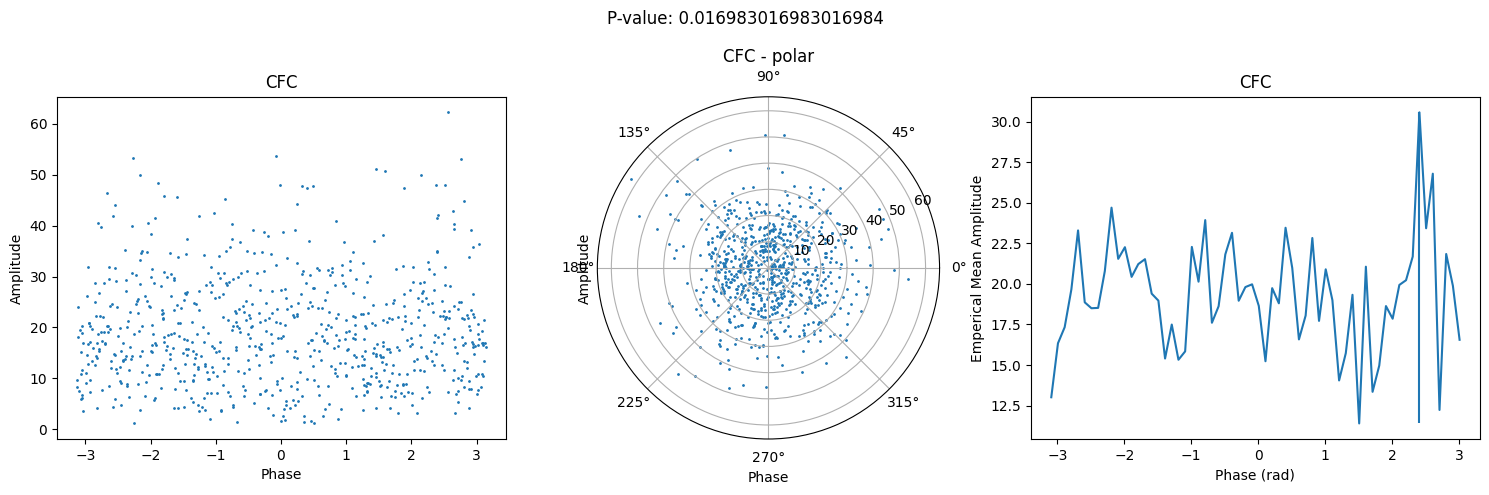

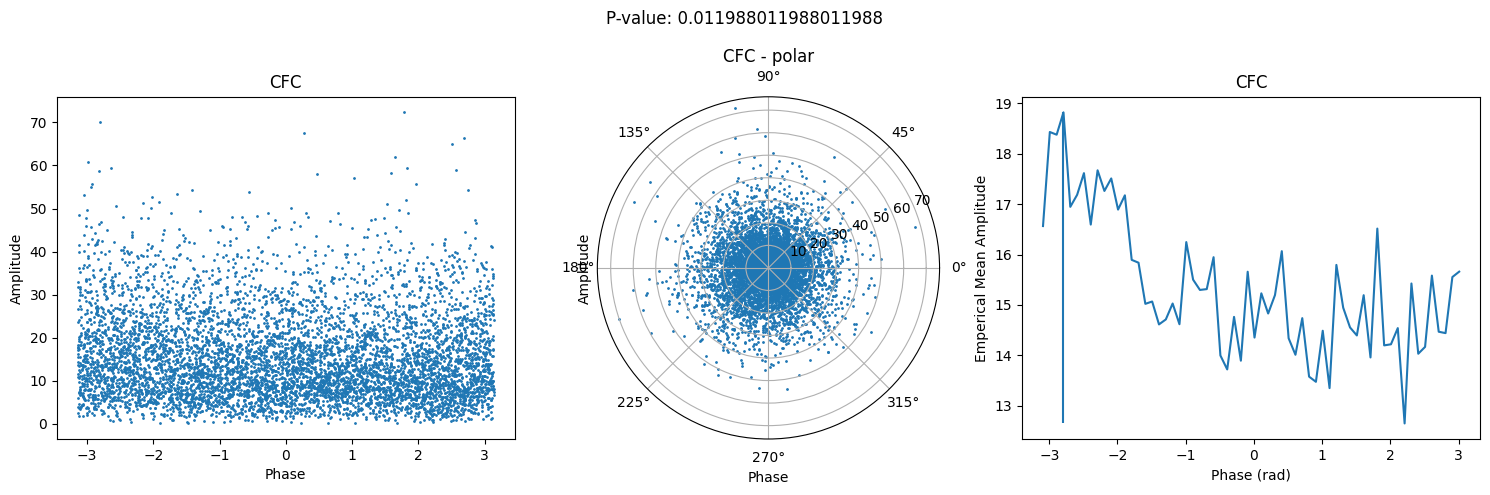

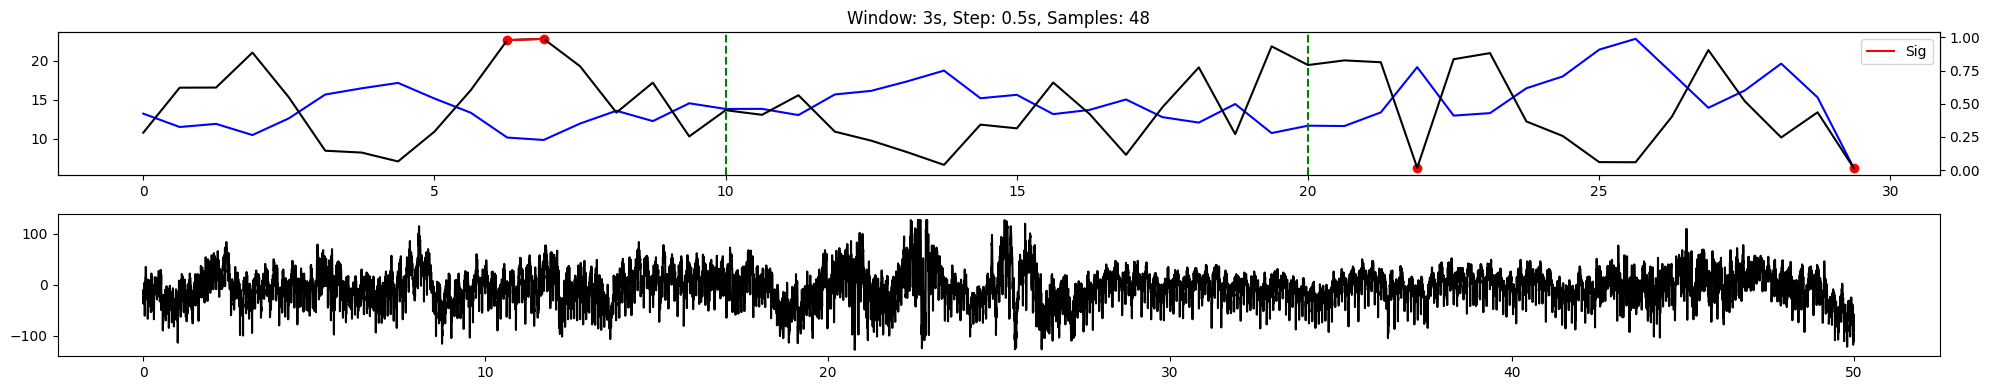

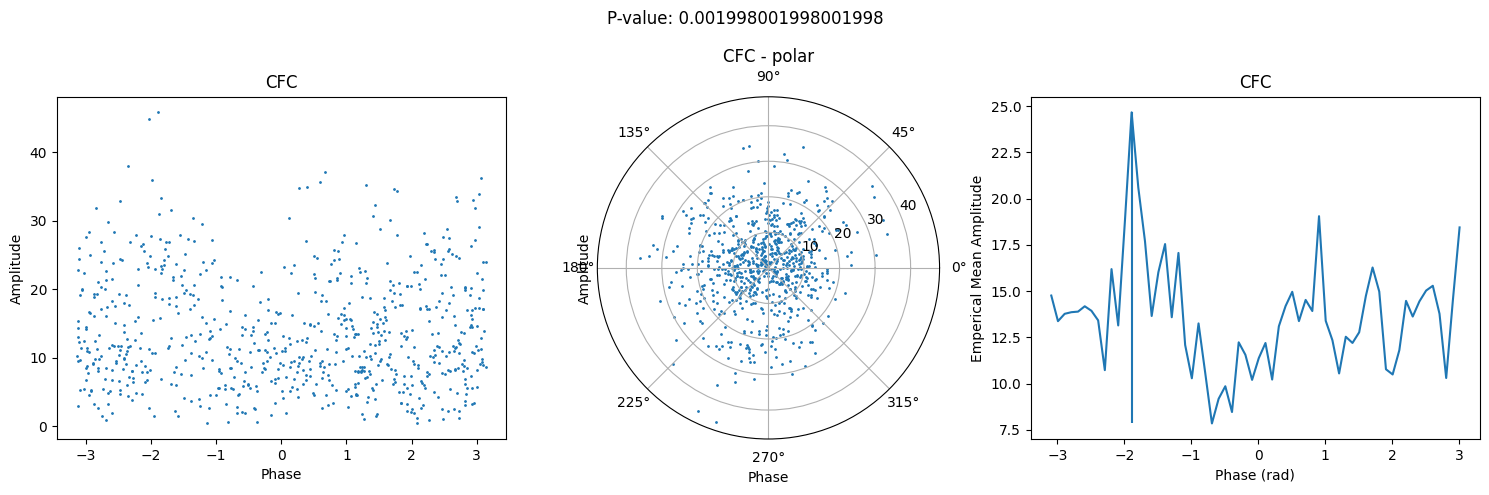

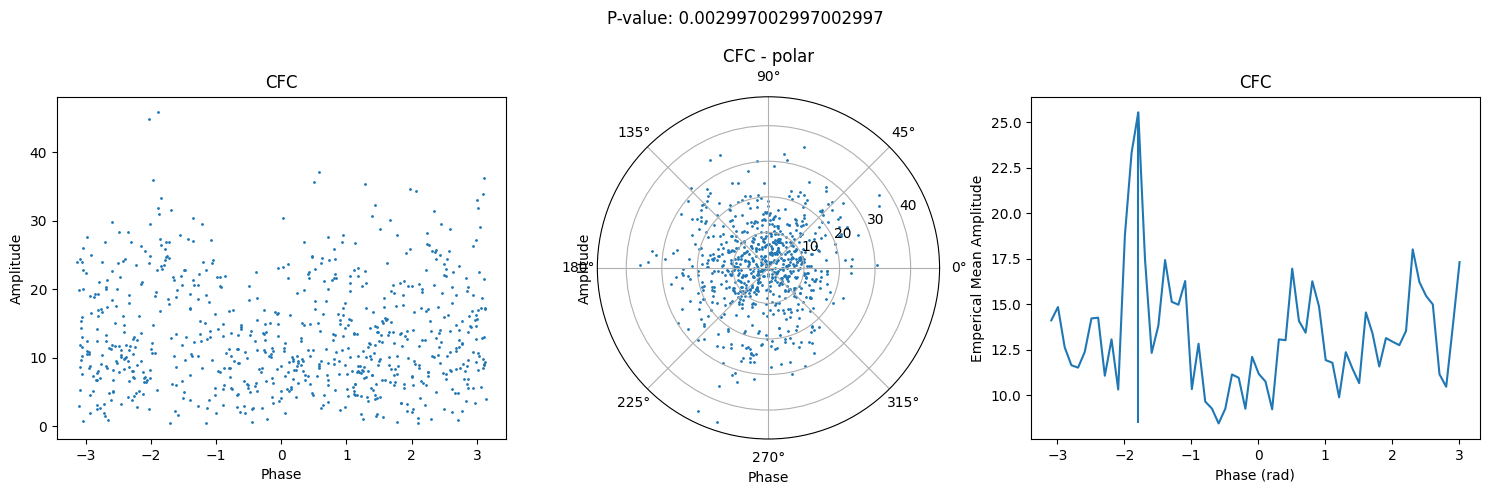

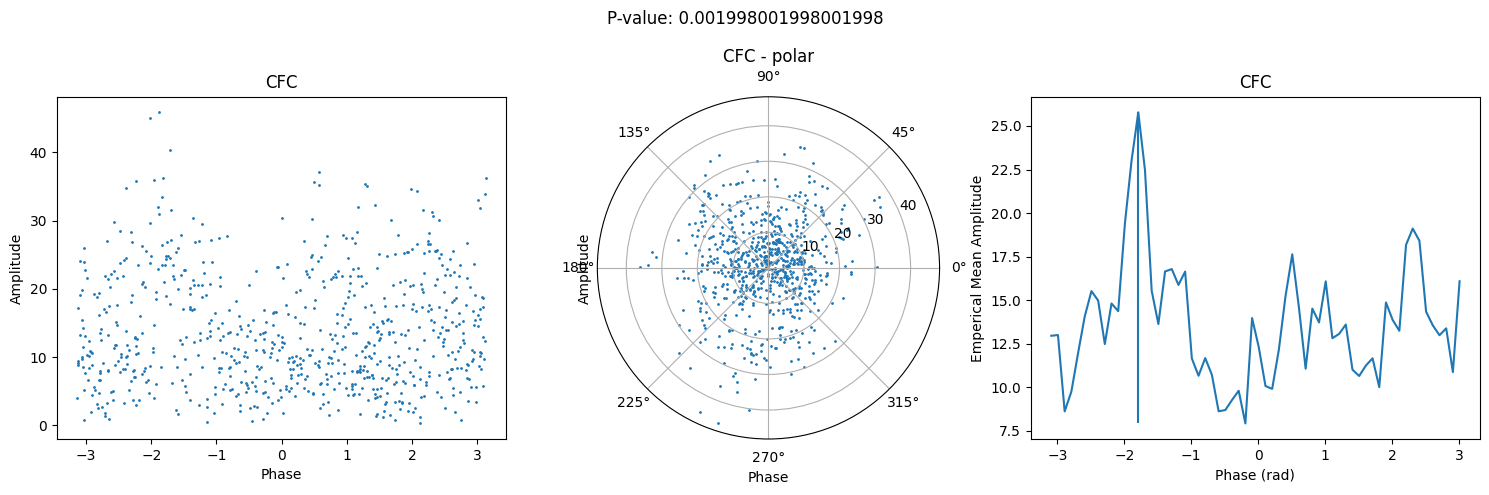

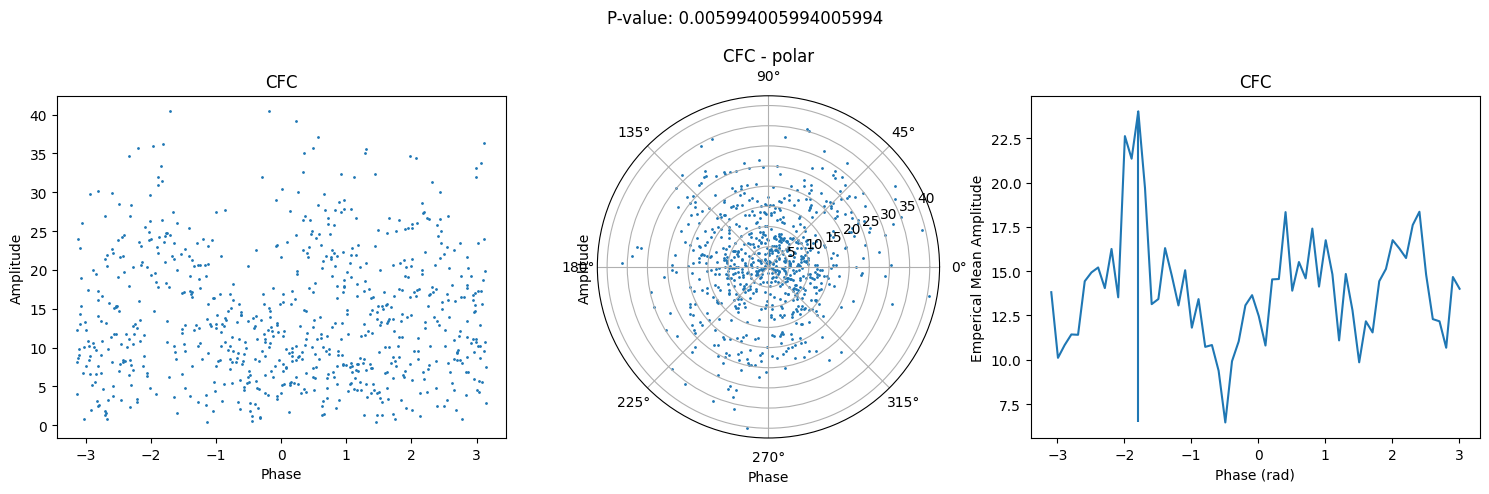

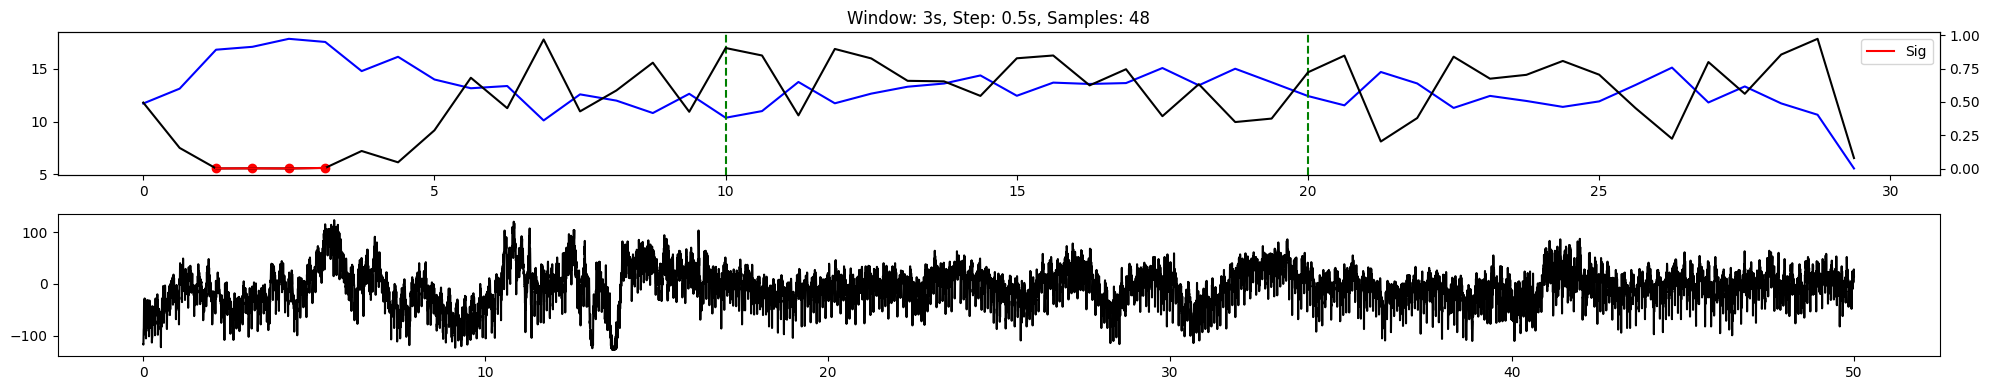

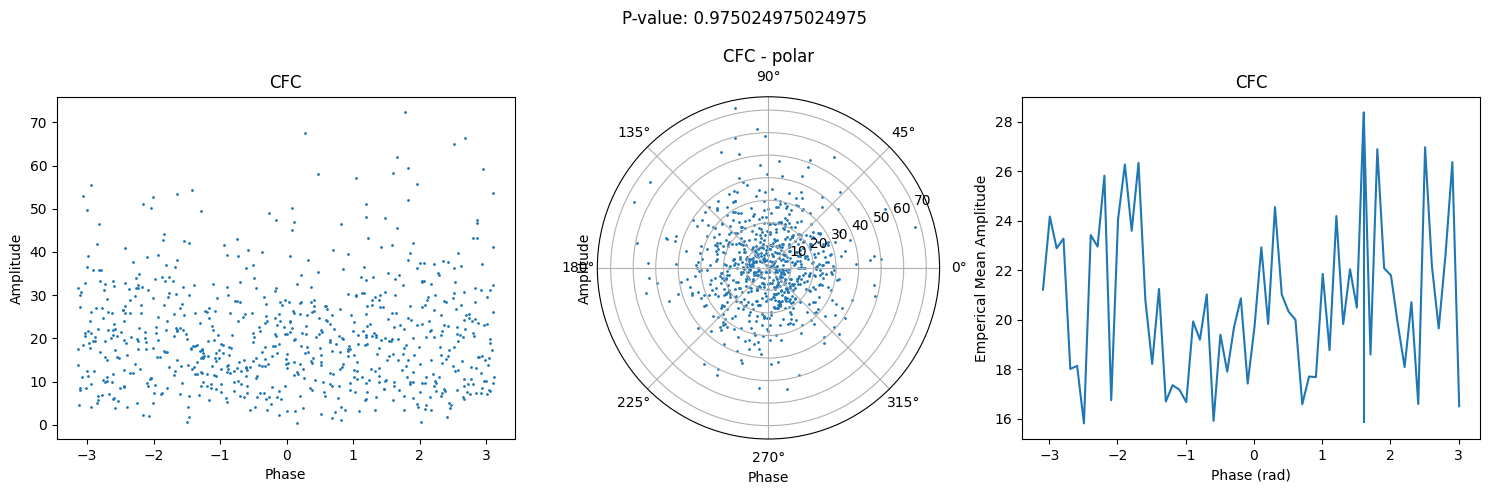

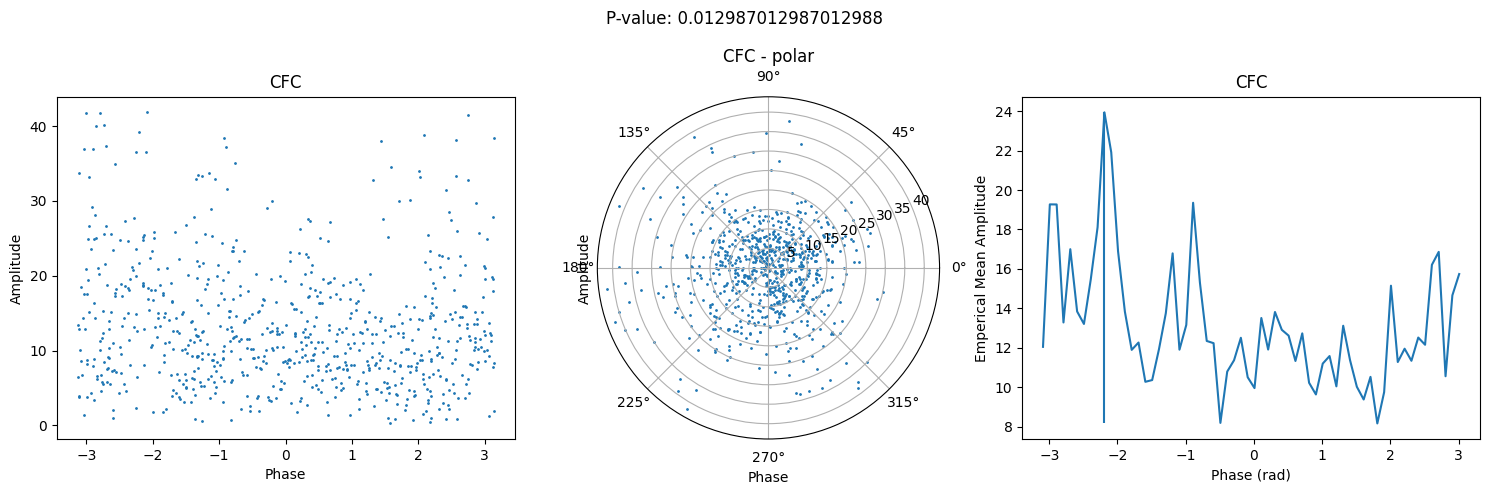

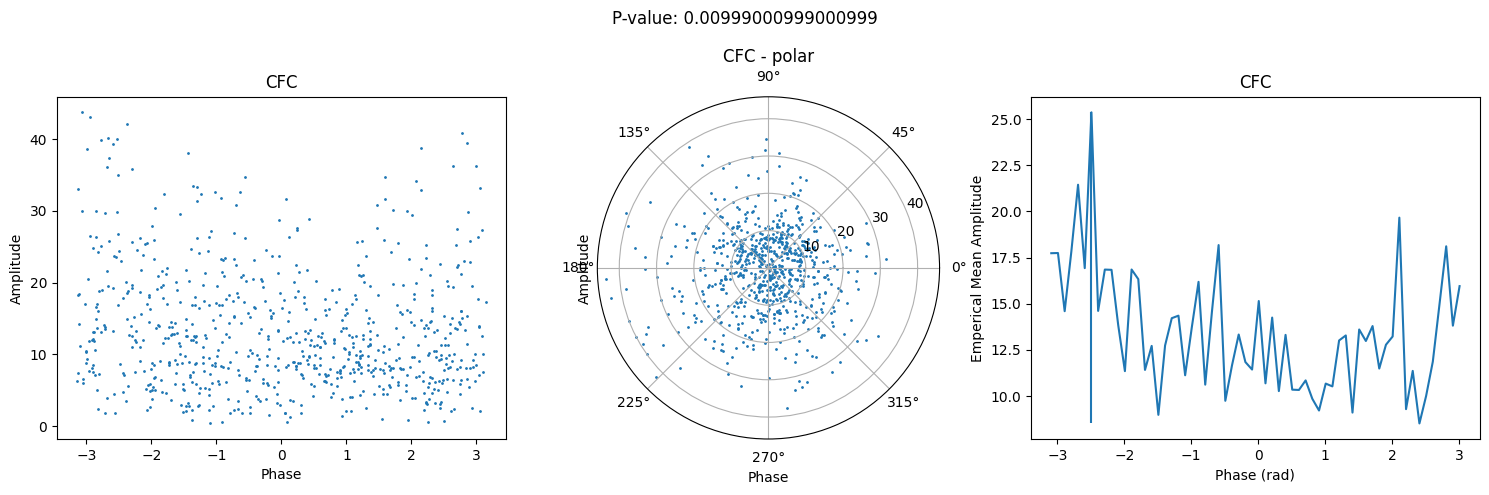

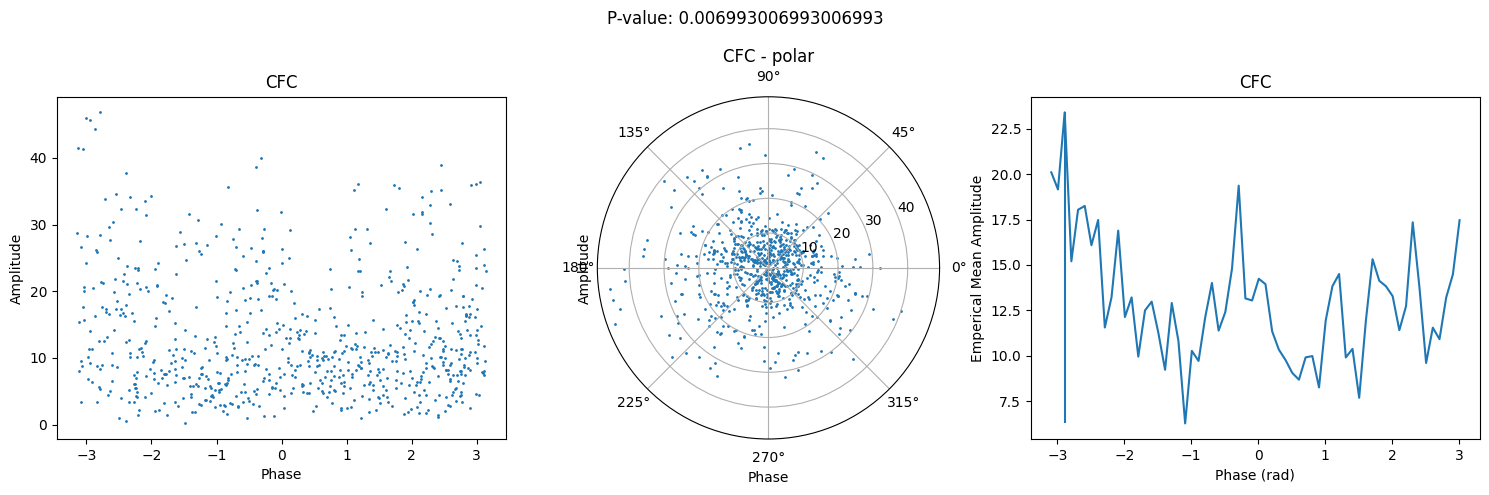

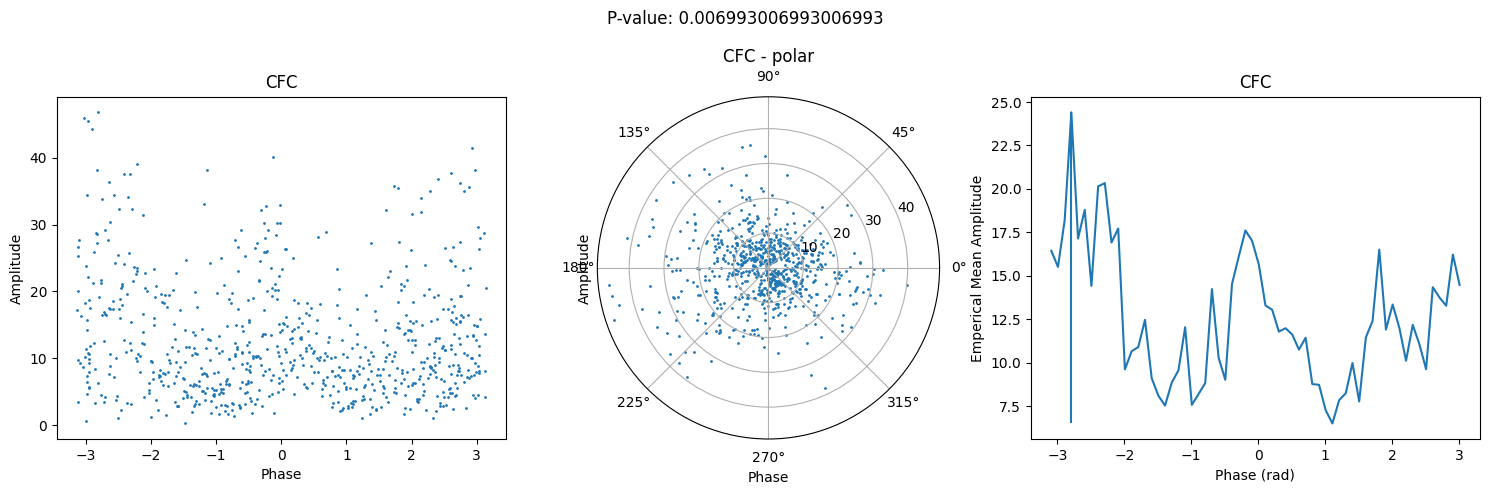

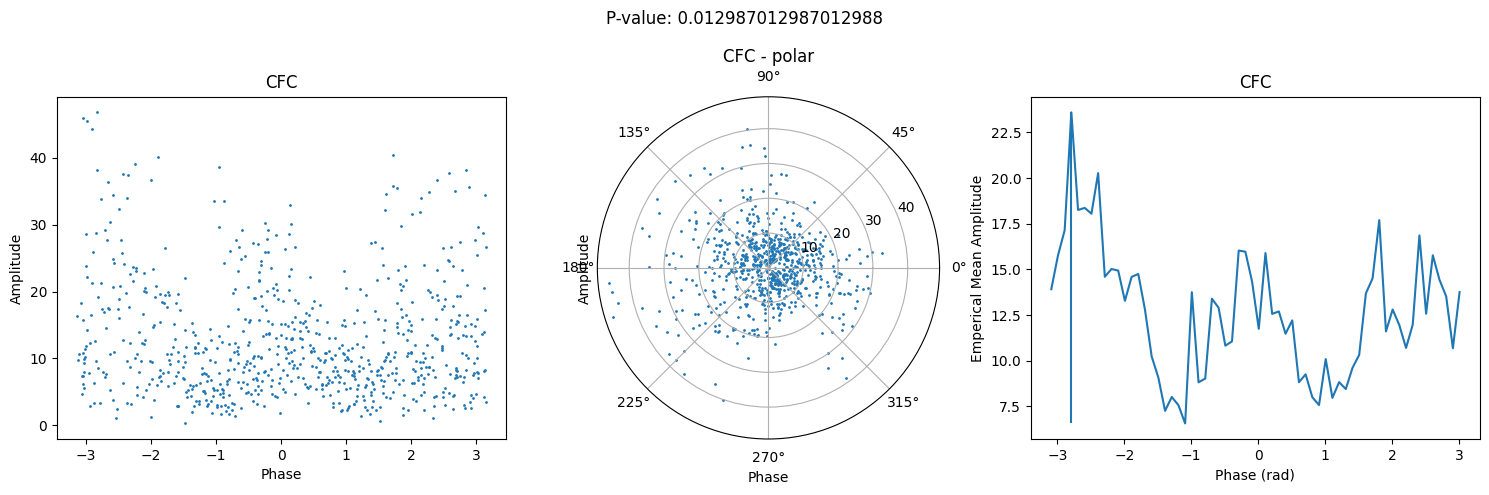

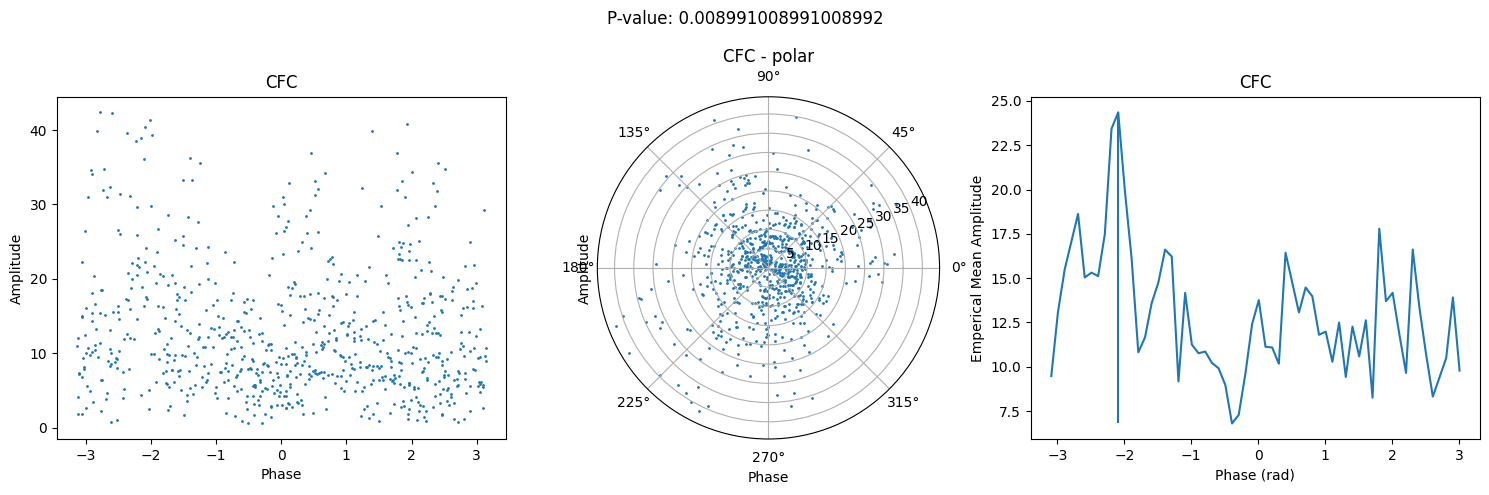

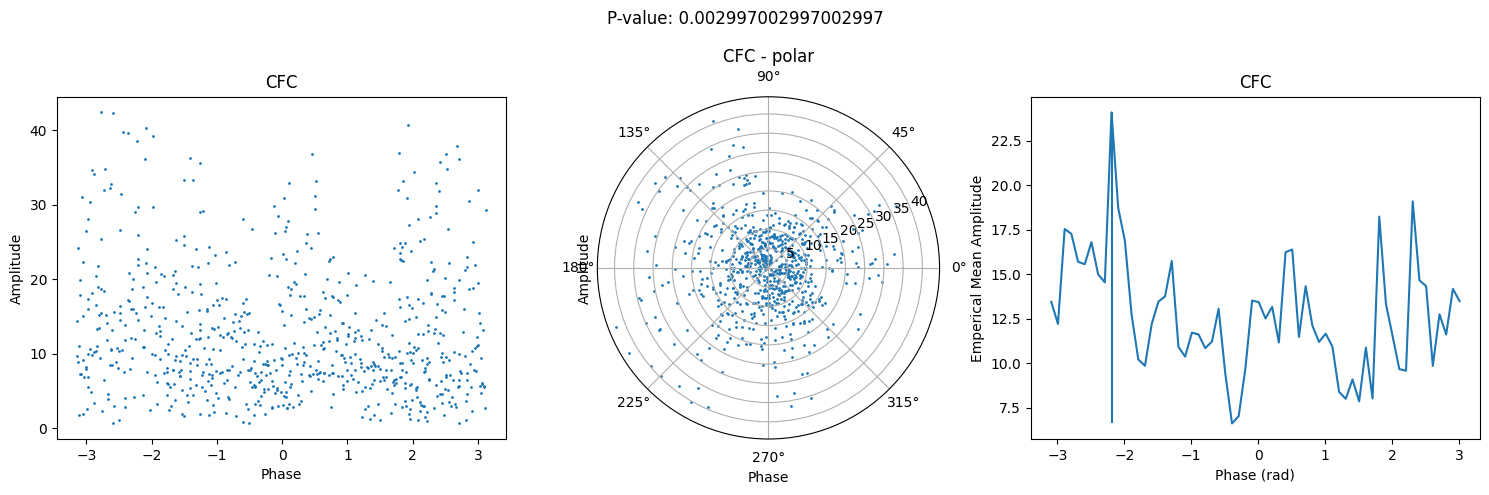

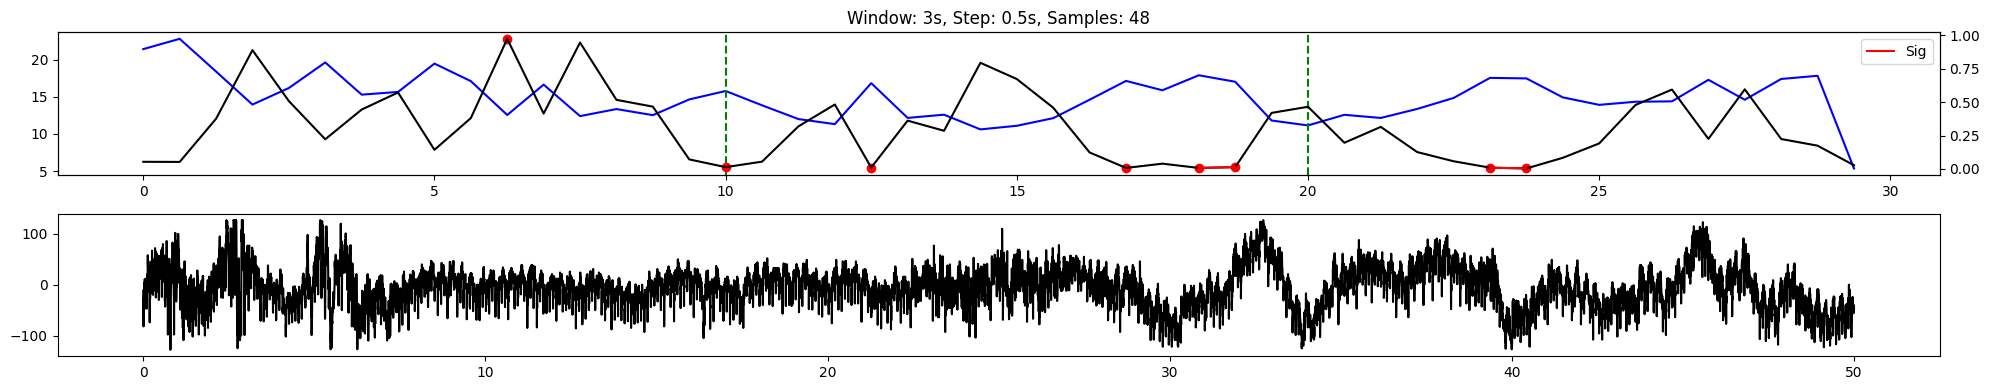

In [27]:
# for i in range(len(eeg_trial_times)):
for trial in range(4):
# for w in [2,4,8,10,15,20,30]:

    Wn = [3, 10] 
    n = 101
    b1 = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming')

    Wn = [30, 120] 
    n = 101
    b2 = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming')

    # t = eeg_trial_times[0]
    # X = eeg_trials[i]

    # end = np.where(t >= 12)[0][0]
    # start = np.where(t <= 8)[0][-1]
    # t = t[start:end]
    # X = X[start:end]
    # print('W is: ' + str(w))
    trial_start_times = np.array([0,50,110,170]) + 5
    approx_odor_p_times = [10,60,120,180]
    trial_length = 20
    # window = w
    window = 3
    step = 0.25
    # t = eeg
    t = eeg_trial_times[0]

    approx_odor_p_times = np.arange(0,trial_length-np.ceil(window/step),step)
    # print(approx_odor_p_times.shape)


    phi = []
    amp = []

    ps = []
    ts = []
    ptimes = []

    for c in range(len(approx_odor_p_times)):
        # print(approx_odor_p_times[k]-window/2,  approx_odor_p_times[k] + window/2)
        # print(t[-1])
        if window > 10:
            start = np.where(t <= approx_odor_p_times[c] - 10)[0][-1]
        else:
            start = np.where(t <= approx_odor_p_times[c])[0][-1]
        # X = eeg[start:end]
        if c == int(len(approx_odor_p_times) - 1):
            X = eeg_trials[trial][start:] 
        else:
            end = np.where(t >= approx_odor_p_times[c]+window)[0][0]
            X = eeg_trials[trial][start:end]

        # print(b1.shape, b2.shape, X.shape)

        Vlo = signal.filtfilt(b1, 1, X, padlen=125)
        Vhi = signal.filtfilt(b2, 1, X, padlen=125)

        # phi = np.hstack((phi,np.angle(signal.hilbert(Vlo))))
        # amp = np.hstack((amp,np.abs(signal.hilbert(Vhi))))
        phi = np.angle(signal.hilbert(Vlo))
        amp = np.abs(signal.hilbert(Vhi))

        p_bins = np.arange(-np.pi,np.pi, 0.1);		
        a_mean = np.zeros(np.size(p_bins)-1)
        p_mean = np.zeros(np.size(p_bins)-1)
        
        for k in range(np.size(p_bins)-1):			
            pL = p_bins[k]				
            pR = p_bins[k+1]				
            indices=(phi>=pL) & (phi<pR)
            a_mean[k] = np.mean(amp[indices])
            p_mean[k] = np.mean([pL, pR])

        store = [phi, p_mean, amp, a_mean, p_bins]

        h = np.max(a_mean)-np.min(a_mean)
        # print("Test Statistic is: " + str(h))

        n_surrogates = 1000
        hS = np.zeros(n_surrogates)			
        for ns in range(n_surrogates):			
            ampS = amp[np.random.randint(0,len(amp),len(amp))]
            p_bins = np.arange(-np.pi, np.pi, 0.1);			
            a_mean = np.zeros(p_bins.size-1);	
            p_mean = np.zeros(p_bins.size-1);	
            for k in range(p_bins.size-1):			
                pL = p_bins[k]				
                pR = p_bins[k+1]				
                indices=(phi>=pL) & (phi<pR)
                a_mean[k] = np.mean(ampS[indices])
                p_mean[k] = np.mean([pL, pR])	
                hS[ns] = max(a_mean)-min(a_mean)

        
        counts, _ = np.histogram(hS)

        # print('p value is: ' + str(p))

        p = (np.sum([val > h for val in hS]) + 1)/(len(hS) + 1)

        if p <= 0.025 or p >= 0.975:
            phi, p_mean, amp, a_mean, p_bins = store
            fig = plt.figure(figsize=(15,5))
            for i in range(3):
                if i != 1:
                    ax = fig.add_subplot(1,3,i+1)
                else:
                    ax = fig.add_subplot(1,3,i+1, projection='polar') 
                if i == 0:
                    ax.scatter(phi, amp, s=1)
                    ax.set_ylabel('Amplitude')
                    ax.set_xlabel('Phase')
                    ax.set_title('CFC')
                if i == 1:
                    ax.scatter(phi, amp, s=1)
                    ax.set_ylabel('Amplitude')
                    ax.set_xlabel('Phase')
                    ax.set_title('CFC - polar')
                if i == 2:
                    ax.plot(p_mean, a_mean)
                    ax.vlines(p_mean[np.argmax(a_mean)], min(a_mean), max(a_mean))
                    ax.set_ylabel('Emperical Mean Amplitude')
                    ax.set_xlabel('Phase (rad)')
                    ax.set_title('CFC')

                fig.suptitle('P-value: ' + str(p))

                fig.tight_layout()

        ps.append(p)
        ts.append(h)
        ptimes.append(approx_odor_p_times[c])

        # print(approx_odor_p_times[c], window, p)

    x_ax = np.arange(0,trial_length, trial_length/len(ps))
    if len(x_ax) > len(ps):
        x_ax = x_ax[:-1]
    # elif len(x_ax) < len(ps):
    #     x_ax = x_ax[:-1]
    # if x_ax[-1] == 30:
    #     x_ax[-1] = np.f

    fig = plt.figure(figsize=(20,4))
    ax = plt.subplot(2,1,1)
    ax.plot(x_ax, ts, color='blue')
    ax2 = ax.twinx()
    ax2.plot(x_ax, ps, color='k')
    ps = np.asarray(ps)
    x_ax = np.asarray(x_ax)
    ids = np.where((ps > 0.025) & (ps < 0.975))[0]
    ps_copy = np.copy(ps)
    ps_copy[ids] = np.nan
    ax2.plot(x_ax,ps_copy, color='r',label='Sig')
    ax2.scatter(x_ax,ps_copy, color='r')
    ax.set_title('Window: ' + str(window) + 's, Step: ' + str(step) + 's, Samples: ' + str(len(ps)))
    ax.axvline(10, color='g', ls='--')
    ax.axvline(20, color='g', ls='--')
    ax2.legend()

    ax = plt.subplot(2,1,2)
    ax.plot(eeg_trial_times[0], eeg_trials[trial], color='k')

    fig.tight_layout()
    plt.show()

    # p_bins = np.arange(-np.pi,np.pi, 0.1);		
    # a_mean = np.zeros(np.size(p_bins)-1)
    # p_mean = np.zeros(np.size(p_bins)-1)
    
    # for k in range(np.size(p_bins)-1):			
    #     pL = p_bins[k]				
    #     pR = p_bins[k+1]				
    #     indices=(phi>=pL) & (phi<pR)
    #     a_mean[k] = np.mean(amp[indices])
    #     p_mean[k] = np.mean([pL, pR])

    # fig = plt.figure(figsize=(15,5))
    # for i in range(3):
    #     if i != 1:
    #         ax = fig.add_subplot(1,3,i+1)
    #     else:
    #         ax = fig.add_subplot(1,3,i+1, projection='polar') 
    #     if i == 0:
    #         ax.scatter(phi, amp, s=1)
    #         ax.set_ylabel('Amplitude')
    #         ax.set_xlabel('Phase')
    #         ax.set_title('CFC')
    #     if i == 1:
    #         ax.scatter(phi, amp, s=1)
    #         ax.set_ylabel('Amplitude')
    #         ax.set_xlabel('Phase')
    #         ax.set_title('CFC - polar')
    #     if i == 2:
    #         ax.plot(p_mean, a_mean)
    #         ax.vlines(p_mean[np.argmax(a_mean)], min(a_mean), max(a_mean), color='r')
    #         ax.set_ylabel('Emperical Mean Amplitude')
    #         ax.set_xlabel('Phase (rad)')
    #         ax.set_title('CFC')
    # fig.tight_layout()

    # fig = plt.figure(figsize=(15,5))
    # plt.vlines(h,0,np.max(counts), 'r', lw=3)
    # # plt.xlim(0,0.15)
    # # plt.ylim(0,300)
    # plt.title('p-value = ' + str(p))
    # plt.xlabel('Peak to Peak Amplitude')
    # plt.ylabel('N')
    # plt.show()

    # print('p value is: ' + str(p))



    # SPATIAL INFORMATION , BORDER, GRID scores
    # SET useMatchedCut = False


In [ ]:
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(2,1,1)
ax.plot(ptimes, ts, color='blue')
ax2 = ax.twinx()
ax2.plot(ptimes, ps, color='k')
ps = np.asarray(ps)
ptimes = np.asarray(ptimes)
ids = np.where((ps > 0.05) & (ps < 0.95))[0]
ps_copy = np.copy(ps)
ps_copy[ids] = np.nan
ax2.plot(ptimes,ps_copy, color='r',label='Sig')
ax2.scatter(ptimes,ps_copy, color='r')
ax.set_title('Window: ' + str(window) + 's, Step: ' + str(step) + 's, Samples: ' + str(len(ps)))
ax.axvline(10, color='g', ls='--')
ax.axvline(20, color='g', ls='--')
ax.legend()

ax = plt.subplot(2,1,2)
ax.plot(eeg_trial_times[0], eeg_trials[1], color='k')

fig.tight_layout()

In [ ]:
n_surrogates = 1000
hS = np.zeros(n_surrogates)			
for ns in range(n_surrogates):			
    ampS = amp[np.random.randint(0,N,N)]
    p_bins = np.arange(-np.pi, np.pi, 0.1);			
    a_mean = np.zeros(p_bins.size-1);	
    p_mean = np.zeros(p_bins.size-1);	
    for k in range(p_bins.size-1):			
      pL = p_bins[k]				
      pR = p_bins[k+1]				
      indices=(phi>=pL) & (phi<pR)
      a_mean[k] = np.mean(ampS[indices])
      p_mean[k] = np.mean([pL, pR])	
    hS[ns] = max(a_mean)-min(a_mean)

fig = plt.figure(figsize=(15,5))
counts, _, _ = plt.hist(hS)
plt.vlines(h,0,np.max(counts), 'r', lw=3)
plt.xlim(0,0.15)
plt.ylim(0,300)
p = (np.sum([val > h for val in hS]) + 1)/(len(hS) + 1)
plt.title('p-value = ' + str(p))
plt.xlabel('Peak to Peak Amplitude')
plt.ylabel('N')
plt.show()

print('p value is: ' + str(p))

In [ ]:
for i in range(len(eeg_trials)):
    plt.plot(eeg_trial_times[0], eeg_trials[i])
    # plt.xlim(5,15)
    plt.show()
